In [1]:
# basics
import os, sys

# arrays
import numpy as np
import pandas as pd
import xarray as xr

from datetime import (
    datetime,
    timedelta
)

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
sys.path.insert(0, '/home/metocean/geocean-nz-ss')
data_path = '/data' #'/data/storm_surge_data/'
os.environ["SSURGE_DATA_PATH"] = data_path

# custom
from sscode.config import data_path, default_region_reduced, default_evaluation_metrics, default_region
from sscode.utils import (
    calculate_relative_winds,
    spatial_gradient
)

# warnings
import warnings
warnings.filterwarnings('ignore')

# this is to allow plots to be centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")
%matplotlib inline

DATA PATH /data


In [2]:
# dataset attrs
datasets_attrs = {
    'era5': ('longitude','latitude',None,'ERA 5 reanalysis','u10','v10'),
    #'cfsr': ('lon','lat',None,'CFSR reanalysis','U_GRD_L103','V_GRD_L103'),
     'cfsr': ('longitude','latitude',None,'CFSR reanalysis','ugrd10m','vgrd10m'),
    'dac': ('longitude','latitude',None,'DAC global reanalysis'),
    'moana': ('lon','lat','site','Moana v2 hindcast'),
    'codec': ('codec_coords_lon','codec_coords_lat','name','CoDEC reanalysis'),
    'uhslc': ('longitude','latitude','name','UHSLC tgs'),
    'linz': ('longitude','latitude','name','LINZ tgs'),
    'other': ('longitude','latitude','name','OTHER tgs'),
    'privtgs': ('longitude','latitude','name','Private tgs')
}

In [3]:
ss_dset = xr.open_zarr(os.path.join(data_path, 'storm_surge_data/moana_hindcast_v2/moana_coast.zarr/'))
ss_dset = ss_dset.isel(site=np.logical_and(ss_dset.lat>-50, ss_dset.lon < 180))
predictand = ss_dset.ss\
                    .sel(time=slice(datetime(1994,12,1), datetime(2017,2,1,1)))\
                    .drop_duplicates('time')\
                    .chunk(dict(time=-1))\
                    .interpolate_na(dim='time')\
                    .transpose()\
                    .load()

In [4]:
def get_best_predictor_for_site(location,
                                dx=2.5,
                                region=None,
                                normalised=True):
    
    from sscode.utils import spatial_gradient
    
    pres_vars = ('SLP','longitude','latitude')
    wind_vars = ('wind_proj_mask','longitude','latitude','U_GRD_L103','V_GRD_L103')
    
    if region is None:
        region = (
                  location[0]-dx,
                  location[0]+dx,
                  location[1]-dx,
                  location[1]+dx
                )
    
    region_large = (
              region[0]-1,
              region[1]+1,
              region[2]-1,
              region[3]+1
            )

    print("Loading U")
    uw = xr.open_dataset(os.path.join(data_path, 'cfsr',
                                      'wnd10m/cfsr_wnd_1979_2021.nc'))[datasets_attrs['cfsr'][4]]\
                    .sel(time=slice(datetime(1994,11,1), datetime(2017,3,1)))\
                    .sel({
                      wind_vars[1]:slice(region_large[0],region_large[1]),
                      wind_vars[2]:slice(region_large[2],region_large[3])
                    })\
                    .sortby(datasets_attrs['cfsr'][0],ascending=True)\
                    .sortby(datasets_attrs['cfsr'][1],ascending=True)
    print("Done")

    print("Loading V")
    vw = xr.open_dataset(os.path.join(data_path, 'cfsr',
                                                  'wnd10m/cfsr_wnd_1979_2021.nc'))[datasets_attrs['cfsr'][5]]\
                    .sel(time=slice(datetime(1994,11,1), datetime(2017,3,1)))\
                    .sel({
                      wind_vars[1]:slice(region_large[0],region_large[1]),
                      wind_vars[2]:slice(region_large[2],region_large[3])
                    })\
                    .sortby(datasets_attrs['cfsr'][0],ascending=True)\
                    .sortby(datasets_attrs['cfsr'][1],ascending=True)
    print("Done")

    print("Calculating relative winds")
    wind = calculate_relative_winds(location=location, # load_winds[1],
                                    lat_name=datasets_attrs['cfsr'][1],
                                    lon_name=datasets_attrs['cfsr'][0],
                                    uw=uw,vw=vw)
    print("Done")

    print("Clearing U,V")
    del uw
    del vw
    print("Done")

    print("Loading MSLP")
    pres = xr.open_dataarray(os.path.join(data_path, 'cfsr',
                                          'CFSR_MSLP_1H_1990_2021.nc'))\
             .sel(time=slice(datetime(1994,11,1), datetime(2017,3,1)))\
             .sel({
                    pres_vars[1]:slice(region[0],region[1]),
                    pres_vars[2]:slice(region[2],region[3])
                    })\
             .sortby('longitude',ascending=True)\
             .sortby('latitude',ascending=True)
    print("Done")
    
    if pres_vars[0]=='wind_proj' or pres_vars[0]=='wind_proj_mask': # when just winds are loaded                                                                               
        pres = pres.fillna(0.0)
    else:
        pres = pres.dropna(dim='time',how='all')
    
    wind = wind[wind_vars[0]].fillna(0.0)\
                             .interp(coords={wind_vars[1]:pres[pres_vars[1]],
                                             wind_vars[2]:pres[pres_vars[2]]})\
                             .sel(time=pres.time) # interp to pressure coords                            
    
    # calculate the gradient                                                            
    print('\n calculating the gradient of the sea-level-pressure fields... \n')
    pres = spatial_gradient(pres,pres_vars[0]) # from utils.py                      
    print('\n pressure/gradient predictor both with shape: \n {} \n'\
            .format(pres[pres_vars[0]].shape))
        
    # Normalising
    if normalised:
        all_predictors =\
           xr.concat([
                      (pres.SLP.expand_dims("channel", -1)-pres.SLP.min())/(pres.SLP.max()-pres.SLP.min()),
                      (pres.SLP_gradient.expand_dims("channel", -1)-pres.SLP_gradient.min())/(pres.SLP_gradient.max()-pres.SLP.min()),
                      (wind.expand_dims("channel", -1)-wind.min())/(wind.max()-wind.min())
                     ],
                     "channel").fillna(0)
    else:
        all_predictors =\
           xr.concat([
                      pres.SLP.expand_dims("channel", -1),
                      pres.SLP_gradient.expand_dims("channel", -1),
                      wind.expand_dims("channel", -1)
                     ],
                     "channel").fillna(0)
    
    return all_predictors

In [5]:
import tensorflow.compat.v2 as tfv2
# pylint: disable=g-classes-have-attributes

# These functions are adapted from
# https://github.com/keras-team/keras/blob/06ba37b8662dea768b3bc8201942f1eb877708e8/keras/preprocessing/timeseries.py
# The main addition is that they targets have been modified to contain both the input grid and the ss output
# That way it is possible to use the dataset to train both heads of the network
    
def sequences_from_indices(array, indices_ds, start_index, end_index):
  dataset = tfv2.data.Dataset.from_tensors(array[start_index : end_index])
  dataset = tfv2.data.Dataset.zip((dataset.repeat(), indices_ds)).map(
      lambda steps, inds: tfv2.gather(steps, inds),  # pylint: disable=unnecessary-lambda
      num_parallel_calls=tfv2.data.AUTOTUNE)
  return dataset

def timeseries_dataset_from_array_seb(
    data,
    targets,
    targets_2,
    sequence_length,
    weights=None,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None):
  """Creates a dataset of sliding windows over a timeseries provided as array.
  This function takes in a sequence of data-points gathered at
  equal intervals, along with time series parameters such as
  length of the sequences/windows, spacing between two sequence/windows, etc.,
  to produce batches of timeseries inputs and targets.
  Args:
    data: Numpy array or eager tensor
      containing consecutive data points (timesteps).
      Axis 0 is expected to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
      `targets[i]` should be the target
      corresponding to the window that starts at index `i`
      (see example 2 below).
      Pass None if you don't have target data (in this case the dataset will
      only yield the input data).
    sequence_length: Length of the output sequences (in number of timesteps).
    sequence_stride: Period between successive output sequences.
      For stride `s`, output samples would
      start at index `data[i]`, `data[i + s]`, `data[i + 2 * s]`, etc.
    sampling_rate: Period between successive individual timesteps
      within sequences. For rate `r`, timesteps
      `data[i], data[i + r], ... data[i + sequence_length]`
      are used for create a sample sequence.
    batch_size: Number of timeseries samples in each batch
      (except maybe the last one).
    shuffle: Whether to shuffle output samples,
      or instead draw them in chronological order.
    seed: Optional int; random seed for shuffling.
    start_index: Optional int; data points earlier (exclusive)
      than `start_index` will not be used
      in the output sequences. This is useful to reserve part of the
      data for test or validation.
    end_index: Optional int; data points later (exclusive) than `end_index`
      will not be used in the output sequences.
      This is useful to reserve part of the data for test or validation.
  Returns:
    A tfv2.data.Dataset instance. If `targets` was passed, the dataset yields
    tuple `(batch_of_sequences, batch_of_targets)`. If not, the dataset yields
    only `batch_of_sequences`.
  Example 1:
  Consider indices `[0, 1, ... 99]`.
  With `sequence_length=10,  sampling_rate=2, sequence_stride=3`,
  `shuffle=False`, the dataset will yield batches of sequences
  composed of the following indices:
  ```
  First sequence:  [0  2  4  6  8 10 12 14 16 18]
  Second sequence: [3  5  7  9 11 13 15 17 19 21]
  Third sequence:  [6  8 10 12 14 16 18 20 22 24]
  ...
  Last sequence:   [78 80 82 84 86 88 90 92 94 96]
  ```
  In this case the last 3 data points are discarded since no full sequence
  can be generated to include them (the next sequence would have started
  at index 81, and thus its last step would have gone over 99).
  Example 2: Temporal regression.
  Consider an array `data` of scalar values, of shape `(steps,)`.
  To generate a dataset that uses the past 10
  timesteps to predict the next timestep, you would use:
  ```python
  input_data = data[:-10]
  targets = data[10:]
  dataset = tfv2.keras.preprocessing.timeseries_dataset_from_array(
      input_data, targets, sequence_length=10)
  for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], data[:10])  # First sequence: steps [0-9]
    assert np.array_equal(targets[0], data[10])  # Corresponding target: step 10
    break
  ```
  Example 3: Temporal regression for many-to-many architectures.
  Consider two arrays of scalar values `X` and `Y`,
  both of shape `(100,)`. The resulting dataset should consist samples with
  20 timestamps each. The samples should not overlap.
  To generate a dataset that uses the current timestamp
  to predict the corresponding target timestep, you would use:
  ```python
  X = np.arange(100)
  Y = X*2
  sample_length = 20
  input_dataset = tfv2.keras.preprocessing.timeseries_dataset_from_array(
    X, None, sequence_length=sample_length, sequence_stride=sample_length)
  target_dataset = tfv2.keras.preprocessing.timeseries_dataset_from_array(
    Y, None, sequence_length=sample_length, sequence_stride=sample_length)
  for batch in zip(input_dataset, target_dataset):
    inputs, targets = batch
    assert np.array_equal(inputs[0], X[:sample_length])
    # second sample equals output timestamps 20-40
    assert np.array_equal(targets[1], Y[sample_length:2*sample_length])
    break
  ```
  """
  if start_index:
    if start_index < 0:
      raise ValueError(f'`start_index` must be 0 or greater. Received: '
                       f'start_index={start_index}')
    if start_index >= len(data):
      raise ValueError(f'`start_index` must be lower than the length of the '
                       f'data. Received: start_index={start_index}, for data '
                       f'of length {len(data)}')
  if end_index:
    if start_index and end_index <= start_index:
      raise ValueError(f'`end_index` must be higher than `start_index`. '
                       f'Received: start_index={start_index}, and '
                       f'end_index={end_index} ')
    if end_index >= len(data):
      raise ValueError(f'`end_index` must be lower than the length of the '
                       f'data. Received: end_index={end_index}, for data of '
                       f'length {len(data)}')
    if end_index <= 0:
      raise ValueError('`end_index` must be higher than 0. '
                       f'Received: end_index={end_index}')

  # Validate strides
  if sampling_rate <= 0:
    raise ValueError(f'`sampling_rate` must be higher than 0. Received: '
                     f'sampling_rate={sampling_rate}')
  if sampling_rate >= len(data):
    raise ValueError(f'`sampling_rate` must be lower than the length of the '
                     f'data. Received: sampling_rate={sampling_rate}, for data '
                     f'of length {len(data)}')
  if sequence_stride <= 0:
    raise ValueError(f'`sequence_stride` must be higher than 0. Received: '
                     f'sequence_stride={sequence_stride}')
  if sequence_stride >= len(data):
    raise ValueError(f'`sequence_stride` must be lower than the length of the '
                     f'data. Received: sequence_stride={sequence_stride}, for '
                     f'data of length {len(data)}')

  if start_index is None:
    start_index = 0
  if end_index is None:
    end_index = len(data)

  # Determine the lowest dtype to store start positions (to lower memory usage).
  num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1
  if targets is not None:
    num_seqs = min(num_seqs, len(targets))
  if num_seqs < 2147483647:
    index_dtype = 'int32'
  else:
    index_dtype = 'int64'

  # Generate start positions
  start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
  if shuffle:
    if seed is None:
      seed = np.random.randint(1e6)
    rng = np.random.RandomState(seed)
    rng.shuffle(start_positions)

  sequence_length = tfv2.cast(sequence_length, dtype=index_dtype)
  sampling_rate = tfv2.cast(sampling_rate, dtype=index_dtype)

  positions_ds = tfv2.data.Dataset.from_tensors(start_positions).repeat()

  # For each initial window position, generates indices of the window elements
  indices = tfv2.data.Dataset.zip(
      (tfv2.data.Dataset.range(len(start_positions)), positions_ds)).map(
          lambda i, positions: tfv2.range(  # pylint: disable=g-long-lambda
              positions[i],
              positions[i] + sequence_length * sampling_rate,
              sampling_rate),
          num_parallel_calls=tfv2.data.AUTOTUNE)

  dataset = sequences_from_indices(data, indices, start_index, end_index)
  outputs = [dataset]
  if targets is not None:
    indices = tfv2.data.Dataset.zip(
        (tfv2.data.Dataset.range(len(start_positions)), positions_ds)).map(
            lambda i, positions: positions[i],
            num_parallel_calls=tfv2.data.AUTOTUNE)
    print(targets.__class__)
    target_ds = sequences_from_indices(
        targets, indices, start_index, end_index)
    
    if targets_2 is not None:
        target_ds_2 = sequences_from_indices(
            targets_2, indices, start_index, end_index)
        outputs.append((target_ds, target_ds_2))
    else:
    #outputs.append((target_ds, dataset))
        outputs.append(target_ds)
    ##dataset = tfv2.data.Dataset.zip((dataset, (target_ds, dataset)))
    
    #outputs.append((target_ds, dataset))
    #outputs.append(target_ds)

  if weights is not None:
    indices = tfv2.data.Dataset.zip(
        (tfv2.data.Dataset.range(len(start_positions)), positions_ds)).map(
            lambda i, positions: positions[i],
            num_parallel_calls=tfv2.data.AUTOTUNE)
    print(weights.__class__)
    target_weights_dset = sequences_from_indices(
            weights, indices, start_index, end_index)
    
    indices = tfv2.data.Dataset.zip(
      (tfv2.data.Dataset.range(len(start_positions)), positions_ds)).map(
          lambda i, positions: tfv2.range(  # pylint: disable=g-long-lambda
              positions[i],
              positions[i] + sequence_length * sampling_rate,
              sampling_rate),
          num_parallel_calls=tfv2.data.AUTOTUNE)

    ae_weights_dset = sequences_from_indices(np.ones(data.shape[:-1]+(1,)), indices, start_index, end_index)
    outputs.append((target_weights_dset, ae_weights_dset))
    #dataset = tfv2.data.Dataset.zip((dataset, (target_ds, dataset)))
  dataset = tfv2.data.Dataset.zip(tuple(outputs))
  if shuffle:
    # Shuffle locally at each iteration
    dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
  dataset = dataset.prefetch(tfv2.data.AUTOTUNE).batch(batch_size)
  return dataset

In [177]:
from sscode.validation import generate_stats
from sscode.config import (
    default_evaluation_metrics,
    default_ext_quantile
)

def calculate_stats(ts1, ts2):
    title, stats = generate_stats(ts1,
                              ts2,
                              metrics=default_evaluation_metrics,
                              ext_quantile=default_ext_quantile)
    for metric in ['bias', 'si',
                   'rmse', 'kgeprime', 'rmse_95', 'rmse_99',
                   'pearson', 'pearson_95', 'pearson_99',
                   'rscore', 'rscore_95', 'rscore_99',
                   'nse', 'nse_95', 'nse_99',
                   'kge', 'ext_kge_95', 'ext_kge_99']:
        print(metric, stats[metric])
    return stats

In [8]:
from tensorflow.keras.layers import (
    Conv2D,
    Conv3D,
    BatchNormalization,
    MaxPool2D,
    MaxPool3D,
    ConvLSTM2D,
    GlobalMaxPool2D,
    Flatten, Dropout,
    TimeDistributed,
    GRU,
    Dense,
    Dropout,
    Conv1D,
    LSTM,
    Conv2DTranspose,
    Reshape,
    Cropping2D,
    Cropping1D,
    Activation,
    Lambda,
    Concatenate,
    TimeDistributed,
    Flatten,
    Reshape
)
import tensorflow as tf
from tensorflow.keras.models import Model

In [9]:
# This one works!!!
def build_model_cnn(shape_in,
                    nbout=1):

    inputs = tf.keras.Input(shape=shape_in)
    
    conv_1 = TimeDistributed(Conv2D(24, (3,3), padding='same', activation='relu'))(inputs)
    cnn_outputs = TimeDistributed(MaxPool2D((2,2)))(conv_1)     
    
    flat = Flatten()(cnn_outputs)

    dense_1 = Dense(48,
                    activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001),
                    )(flat)
    
    dropout_1 = Dropout(0.1)(dense_1)
    
    out = Dense(nbout,
                activation='linear',
                use_bias=True)(dropout_1)

    model = Model(inputs=inputs, outputs=out)

    print(model.summary())
    
    return model

In [10]:
import tensorflow as tf

to_use=1

gpus = tf.config.list_physical_devices('GPU')

try:
    tf.config.set_visible_devices(gpus[to_use], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    print("Failed to select GPU")

2 Physical GPUs, 1 Logical GPU


In [168]:
def get_training_and_validation_sets(predictors,
                                     predictand,
                                     input_sequence_length,
                                     input_sequence_frequency,
                                     lead_time,
                                     target_sequence_frequency,
                                     fold=0,
                                     n_folds=5,
                                     batch_size=32,
                                     print_test=False):
    
    if ( not (predictand.time.values[1:]-predictand.time.values[:-1]).max() ==\
        (predictand.time.values[1:]-predictand.time.values[:-1]).min() ):
        print("Time spacing is not constant in predictand dataset")
        raise
    
    if ( not (predictors.time.values[1:]-predictors.time.values[:-1]).max() ==\
        (predictors.time.values[1:]-predictors.time.values[:-1]).min() ):
            print("Time spacing is not constant in predictor dataset")
            raise
    
    # Find start, end and extent of dataset
    [tstart_predictor, tend_predictor] = predictors.time.values[[0,-1]].astype('datetime64[s]').tolist()
    [tstart_predictand, tend_predictand] = predictand.time.values[[0,-1]].astype('datetime64[s]').tolist()
    tstart = max(tstart_predictand, tstart_predictor)
    tend = min(tend_predictand, tend_predictor)
    time_extent = tend - tstart

    print("Returning fold ",fold," of ", n_folds, " e.g. %2.1f percent training data"%((n_folds-1)/n_folds*100.))

    # Finding time bounds of training data segments
    tstart_1 = tstart
    tend_1 = (tstart + time_extent*((n_folds-1-fold)/n_folds)).replace(second=0, microsecond=0, minute=0)

    tstart_2 = (tstart + time_extent*((n_folds-fold)/n_folds)).replace(second=0, microsecond=0, minute=0)
    tend_2 = tend
    print("")
    
    train_dset = []
    for tstart_train, tend_train in zip([tstart_1, tstart_2],[tend_1, tend_2]):
        if tstart_train != tend_train:
            print(tstart_train, tend_train)

            predictor_train =\
                predictors.sel(time=slice(tstart_train,
                                          tend_train-timedelta(hours=(lead_time-target_sequence_frequency))))\
                          .rolling(time=input_sequence_frequency).mean()\
                          .shift(time=-(input_sequence_frequency-1))\
                          .isel(time=slice(0,-(input_sequence_frequency-1)))\
                          .fillna(0)

            ss_train = predictand.sel(time=slice(tstart_train+timedelta(hours=input_sequence_length+lead_time-target_sequence_frequency),
                                      tend_train))\
                                 .chunk(dict(time=-1))\
                                 .interpolate_na(dim='time')\
                                 .rolling(time=target_sequence_frequency).max()\
                                 .shift(time=-(target_sequence_frequency-1))\
                                 .isel(time=slice(0,-(target_sequence_frequency-1)))\
                                 .expand_dims("channel", -1)*100

            if print_test: # To check indices are fine
                test_dset = timeseries_dataset_from_array_seb(
                    (predictor_train.time.values.astype(np.int)-786412800000000000)//3600000000000,
                    (ss_train.time.values.astype(np.int)-786412800000000000)//3600000000000,
                    targets_2=None,
                    weights=None,
                    sequence_length=int(input_sequence_length/input_sequence_frequency),
                    sequence_stride=int(target_sequence_frequency/input_sequence_frequency),
                    sampling_rate=input_sequence_frequency,
                    batch_size=4, shuffle=True, seed=None, start_index=None, end_index=None
                    )
        
                print("All integer correspond to number of hours with respect to reference date")
                for batch in test_dset:
                    inputs, targets = batch
                    for v1, v2 in zip(inputs, targets):
                        print("Times in:", v1, "Times out:", v2)
                    print_test = False
                    break
                print("")

            train_dset.append(timeseries_dataset_from_array_seb(
                    predictor_train,
                    ss_train,
                    targets_2=None,
                weights=None,
                sequence_length=int(input_sequence_length/input_sequence_frequency),
                sequence_stride=int(target_sequence_frequency/input_sequence_frequency),
                sampling_rate=input_sequence_frequency,
                batch_size=batch_size, shuffle=True, seed=None, start_index=None, end_index=None
                ))
            
    # If multiple segments concatenate them into a single dataset
    if len(train_dset) == 1:
        train_dset = train_dset[0]
    else:
        assert len(train_dset) == 2
        train_dset = train_dset[0].concatenate(train_dset[1])


    # Validation data
    predictor_val = predictors.sel(time=slice(tend_1,
                                              tstart_2-timedelta(hours=(lead_time-target_sequence_frequency))))\
                              .rolling(time=input_sequence_frequency).mean()\
                              .shift(time=-(input_sequence_frequency-1))\
                              .isel(time=slice(0,-(input_sequence_frequency-1)))\
                              .fillna(0)

    ss_val = predictand.sel(time=slice(tend_1+timedelta(hours=input_sequence_length+lead_time-target_sequence_frequency),
                                       tstart_2))\
                       .chunk(dict(time=-1))\
                       .interpolate_na(dim='time')\
                       .rolling(time=target_sequence_frequency).max()\
                       .shift(time=-(target_sequence_frequency-1))\
                       .isel(time=slice(0,-(target_sequence_frequency-1)))\
                       .expand_dims("channel", -1)*100


    val_dset = timeseries_dataset_from_array_seb(
        predictor_val,
        ss_val,
        targets_2=None,
        weights=None,
        sequence_length=int(input_sequence_length/input_sequence_frequency),
        sequence_stride=int(target_sequence_frequency/input_sequence_frequency),
        sampling_rate=input_sequence_frequency,
        batch_size=batch_size, shuffle=False, seed=None, start_index=None, end_index=None
    )

    return train_dset, val_dset

In [261]:
results = {}
#for site_id in [ 224 ]:
for site_id in np.unique( # closest Moana v2 Hindcast to tidal gauges
                [ 689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
                  1296,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
                  1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
                ]
            ):
    
    
    location = (float(ss_dset.sel(site=site_id).lon.values),
                    float(ss_dset.sel(site=site_id).lat.values))
    
    
    all_predictors = get_best_predictor_for_site(location)
    
    results[site_id]={}
    
    
    
    for fold in range(5):
        
    #try:
    #if True:

        dset_train, dset_val = get_training_and_validation_sets(predictors=all_predictors,
                                                        predictand=predictand.sel(site=site_id),
                                                        input_sequence_length=input_sequence_length,
                                                        input_sequence_frequency=input_sequence_frequency,
                                                        lead_time=lead_time,
                                                        target_sequence_frequency=target_sequence_frequency,
                                                        batch_size=32,
                                                        n_folds=5,
                                                        fold=fold,
                                                        print_test=True
                                                               )


        shape_in=(int(input_sequence_length/input_sequence_frequency),) + dset_train.element_spec[0].shape[2:]
        model_cnn = build_model_cnn(shape_in=shape_in,
                                    nbout=dset_train.element_spec[1].shape[1])

        optimizer = tf.keras.optimizers.Adam(0.0001)
        model_cnn.compile(
                optimizer,
                loss='mse', 
                metrics=['mse', 'mae'],
        )

        history = model_cnn.fit(dset_train,
                                validation_data=dset_val,
                                epochs=20)

        prediction_val = model_cnn.predict(dset_val)

        results[site_id][fold] = calculate_stats(np.concatenate([y.numpy()[:,0] for x, y in dset_val], axis=0)/100, prediction_val[:,0]/100)
        results[site_id][fold]['history'] = history
        w_results[site_id][fold]['prediction'] = prediction_val
        

Loading U
Done
Loading V
Done
Calculating relative winds

 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.11 -49.8 -49.49 ... -43.56 -43.24
  * longitude       (longitude) float32 165.0 165.3 165.6 ... 170.9 171.2 171.6
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -9.86 -9.789 ... -2.205
    vgrd10m         (time, latitude, longitude) float32 11.66 11.62 ... 2.572
    uw2             (time, latitude, longitude) float32 97.21 95.83 ... 4.861
    vw2             (time, latitude, longitude) float32 135.9 135.0 ... 6.617
    wind_magnitude  (time, latitude, longitude) float32 15.27 15.19 ... 3.388
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 



KeyboardInterrupt: 

In [265]:
metric = 'pearson'
site_id = 116
#for fold, res in new_results[site_id].items():
for site_id in results.keys():
        print(site_id, np.round([r[metric] for r in results[site_id].values()], 3), np.mean([r[metric] for r in results[site_id].values()]))


116 [0.85  0.863 0.866 0.857 0.87 ] 0.8613134188662361
200 [0.865 0.879 0.865 0.855 0.87 ] 0.8666296471974133
224 [0.812 0.845 0.838 0.811 0.844] 0.830150901523344
328 [0.799 0.841 0.81  0.788 0.819] 0.8116797462112617
393 [0.863 0.871 0.867 0.85  0.877] 0.86562029695218
480 [0.788 0.82  0.794 0.768 0.798] 0.7937408005973807
488 [0.788 0.821 0.796 0.777 0.793] 0.7950268220251023
578 [0.796 0.83  0.816 0.767 0.803] 0.8026105017565566
613 [0.862 0.876 0.864 0.83  0.869] 0.860105138391971
689 [0.841 0.867 0.844 0.826 0.848] 0.8447627955420692
708 [0.78  0.796 0.8   0.747 0.773] 0.779017156731028
744 [0.779 0.8   0.805 0.745 0.779] 0.781703093046672
780 [0.844 0.858 0.846 0.817 0.843] 0.8415980526407582
803 [0.794 0.81  0.803 0.753 0.777] 0.7875990644641302
949 [0.825 0.842 0.828 0.799 0.821] 0.8228952986869453
999 [0.877 0.877 0.854 0.853 0.872] 0.8664577313655633
1025 [0.828 0.822 0.824 0.804 0.813] 0.8185264109361607
1064 [0.881 0.879 0.858 0.854 0.874] 0.8690669773551983
1124 [0.824 0.

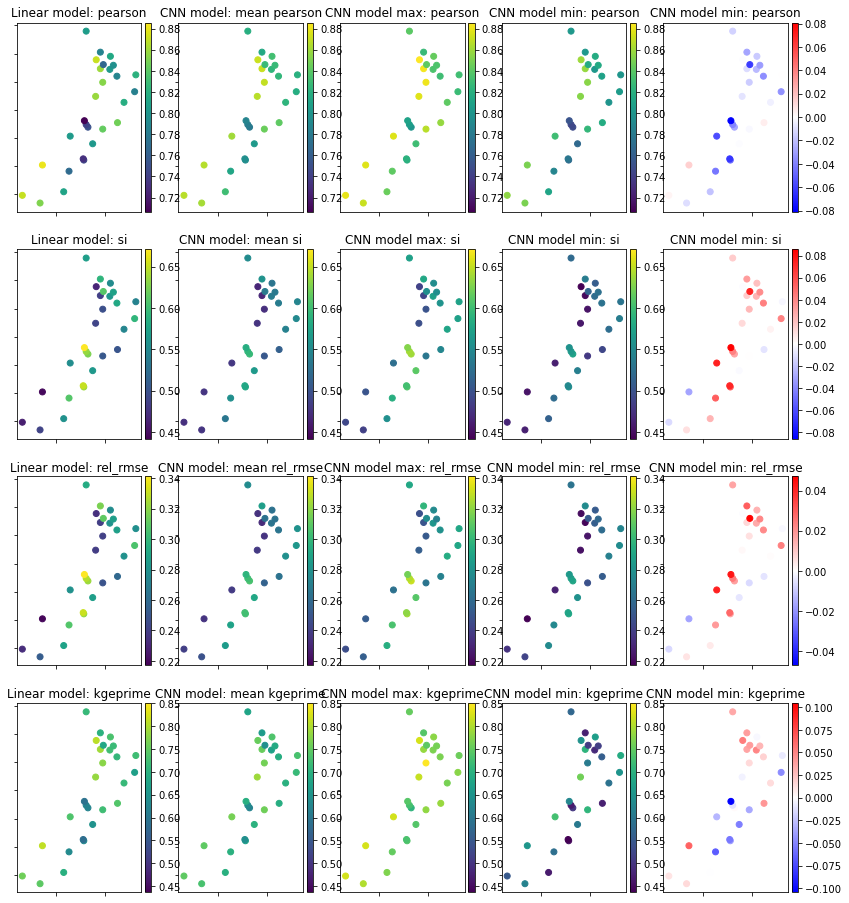

In [270]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

linear_results = xr.open_dataset('/home/metocean/geocean-nz-ss/data/statistics/experiments/experiment_linear_final_20211113.nc')
best_linear_results = linear_results.sel(grad=True, winds=True, tlapse=3, region='local_2.5_2.5', tresample='1D')
best_linear_results

sites = [s for s in best_linear_results.site.values if s in results]
metric = 'ext_kge_99'
metric = 'pearson'
metrics = ['pearson', 'si', 'rel_rmse', 'kgeprime']

lons = ss_dset.sel(site=sites).lon.values
lats = ss_dset.sel(site=sites).lat.values

fig, axes = plt.subplots(ncols=5, nrows=len(metrics), figsize=(14,4*len(metrics)))

for im, metric in enumerate(metrics):
    
    vals_linear = best_linear_results.sel(site=sites)[metric].values
    vals_nn = [np.mean([r[metric] for r in results[s].values()]) for s in sites]
    vals_nn_max = [np.max([r[metric] for r in results[s].values()]) for s in sites]
    vals_nn_min = [np.min([r[metric] for r in results[s].values()]) for s in sites]
    
    vals_diff = np.array(vals_linear).squeeze() - np.array(vals_nn).squeeze()
    vdiff_max = np.max(np.abs(vals_diff))
    
    vmin = np.min([np.min(vals_linear), np.min(vals_nn), np.min(vals_nn_max), np.min(vals_nn_min)])
    vmax = np.max([np.max(vals_linear), np.max(vals_nn), np.max(vals_nn_max), np.max(vals_nn_min)])

    p=axes[im,0].scatter(lons, lats,
                      c=vals_linear, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,0].set_yticklabels([])
    axes[im,0].set_xticklabels([])
    axes[im,0].set_title("Linear model: "+metric)

    p=axes[im,1].scatter(lons, lats,
                      c=vals_nn, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,1].set_yticklabels([])
    axes[im,1].set_xticklabels([])
    axes[im,1].set_title("CNN model: mean "+metric)

    p=axes[im,2].scatter(lons, lats,
                      c=vals_nn_max, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,2].set_yticklabels([])
    axes[im,2].set_xticklabels([])
    axes[im,2].set_title("CNN model max: "+metric)

    p=axes[im,3].scatter(lons, lats,
                      c=vals_nn_min, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,3])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,3].set_yticklabels([])
    axes[im,3].set_xticklabels([])
    axes[im,3].set_title("CNN model min: "+metric)
    
    p=axes[im,4].scatter(lons, lats,
                      c=vals_diff, cmap='bwr', vmin=-vdiff_max, vmax=vdiff_max)
    divider = make_axes_locatable(axes[im,4])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,4].set_yticklabels([])
    axes[im,4].set_xticklabels([])
    axes[im,4].set_title("CNN model min: "+metric)

#for v1,v2,v3 in zip(vals_nn, vals_nn_max, vals_nn_min):
#    print(v1,v2,v3)


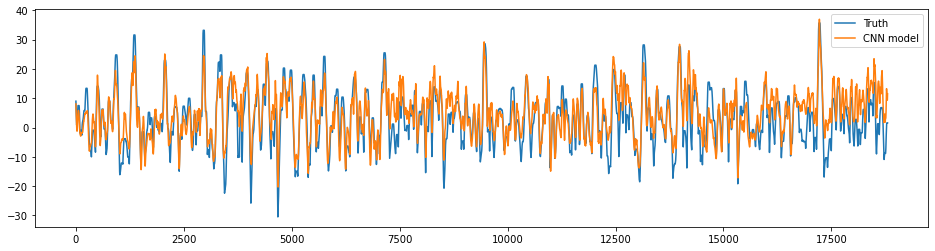

In [187]:
#fig, axes = plt.subplots(figure=(16,4))
#axes.plot(np.concatenate([y.numpy()[:,0] for x, y in dset_val], axis=0))
#axes.plot(prediction_val[:,0])

from matplotlib import pyplot as plt
fig,axes = plt.subplots(figsize=(16,4))
plt.plot(np.concatenate([y.numpy()[:,0] for x, y in dset_val], axis=0)[20000:40000], label='Truth')
plt.plot(prediction_val[20000:40000,0], label='CNN model')
plt.legend()

In [ ]:
results = {}
#for site_id in [ 224 ]:
#for site_id in np.unique( # closest Moana v2 Hindcast to tidal gauges
#                [ 689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
#                  1296,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
#                  1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
#                ]
#            ):
for site_id in ss_dset.site.values: 
    
    if site_id in results:
        continue
    
    location = (float(ss_dset.sel(site=site_id).lon.values),
                    float(ss_dset.sel(site=site_id).lat.values))
    
    
    all_predictors = get_best_predictor_for_site(location)
    
    results[site_id]={}
    
    
    
    for fold in range(1):
        
    #try:
    #if True:

        dset_train, dset_val = get_training_and_validation_sets(predictors=all_predictors,
                                                        predictand=predictand.sel(site=site_id),
                                                        input_sequence_length=input_sequence_length,
                                                        input_sequence_frequency=input_sequence_frequency,
                                                        lead_time=lead_time,
                                                        target_sequence_frequency=target_sequence_frequency,
                                                        batch_size=32,
                                                        n_folds=5,
                                                        fold=fold,
                                                        print_test=True
                                                               )


        shape_in=(int(input_sequence_length/input_sequence_frequency),) + dset_train.element_spec[0].shape[2:]
        model_cnn = build_model_cnn(shape_in=shape_in,
                                    nbout=dset_train.element_spec[1].shape[1])

        optimizer = tf.keras.optimizers.Adam(0.0001)
        model_cnn.compile(
                optimizer,
                loss='mse', 
                metrics=['mse', 'mae'],
        )

        history = model_cnn.fit(dset_train,
                                validation_data=dset_val,
                                epochs=20)

        prediction_val = model_cnn.predict(dset_val)

        results[site_id][fold] = calculate_stats(np.concatenate([y.numpy()[:,0] for x, y in dset_val], axis=0)/100, prediction_val[:,0]/100)
        results[site_id][fold]['history'] = history.history
        results[site_id][fold]['prediction'] = prediction_val
        

Loading U
Done
Loading V
Done
Calculating relative winds

 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 23, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.74 -50.42 -50.11 ... -44.18 -43.87
  * longitude       (longitude) float32 164.1 164.4 164.7 ... 170.3 170.6 170.9
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -10.71 -10.57 ... 0.5726
    vgrd10m         (time, latitude, longitude) float32 11.67 11.77 ... -0.517
    uw2             (time, latitude, longitude) float32 114.7 111.7 ... 0.3278
    vw2             (time, latitude, longitude) float32 136.2 138.5 ... 0.2673
    wind_magnitude  (time, latitude, longitude) float32 15.84 15.82 ... 0.7714
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([87161 87185 87209], shape=(3,), dtype=int64) Times out: tf.Tensor(87209, shape=(), dtype=int64)
Times in: tf.Tensor([20545 20569 20593], shape=(3,), dtype=int64) Times out: tf.Tensor(20593, shape=(), dtype=int64)
Times in: tf.Tensor([9479 9503 9527], shape=(3,), dtype=int64) Times out: tf.Tensor(9527, shape=(), dtype=int64)
Times in: tf.Tensor([8879 8903 8927], shape=(3,), dtype=int64) Times out: tf.Tensor(8927, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_535"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_536 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1070 (TimeD (None, 3, 10, 10, 24)     672       
_________

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 45.3039 - mse: 45.2475 - mae: 5.1906 - val_loss: 31.5937 - val_mse: 31.5233 - val_mae: 4.5098
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.9054 - mse: 34.8283 - mae: 4.6079 - val_loss: 30.6582 - val_mse: 30.5745 - val_mae: 4.4402
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.0197 - mse: 33.9314 - mae: 4.5487 - val_loss: 30.2487 - val_mse: 30.1562 - val_mae: 4.4087
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.7344 - mse: 33.6391 - mae: 4.5286 - val_loss: 29.8623 - val_mse: 29.7634 - val_mae: 4.3825
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.3718 - mse: 33.2702 - mae: 4.5025 - val_loss: 29.9125 - val_mse: 29.8078 - val_mae: 4.3861
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.1477 - mse: 33.0397 - mae: 4.4924 - val_loss: 29.8560 - val_mse: 29.744

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.4272 - mse: 31.2876 - mae: 4.3700 - val_loss: 29.7317 - val_mse: 29.5889 - val_mae: 4.3752
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.4098 - mse: 31.2635 - mae: 4.3620 - val_loss: 29.3469 - val_mse: 29.1972 - val_mae: 4.3529
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.0909 - mse: 30.9375 - mae: 4.3387 - val_loss: 28.8780 - val_mse: 28.7215 - val_mae: 4.3219
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.6217 - mse: 30.4612 - mae: 4.3133 - val_loss: 28.6819 - val_mse: 28.5181 - val_mae: 4.3081
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.4817 - mse: 30.3145 - mae: 4.2988 - val_loss: 28.5359 - val_mse: 28.3663 - val_mae: 4.2952
Epoch 13/20
4857/4857 [==============================] - 8s 2ms/step - loss: 30.1522 - mse: 29.9798 - mae: 4.2747 - val_loss: 28.7025 - val_mse: 28

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.6830 - mse: 30.5309 - mae: 4.3229 - val_loss: 28.4276 - val_mse: 28.2738 - val_mae: 4.2886
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.4466 - mse: 30.2917 - mae: 4.3007 - val_loss: 28.0749 - val_mse: 27.9187 - val_mae: 4.2613
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.3830 - mse: 30.2258 - mae: 4.2973 - val_loss: 28.6289 - val_mse: 28.4707 - val_mae: 4.2997
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.2021 - mse: 30.0432 - mae: 4.2849 - val_loss: 28.4039 - val_mse: 28.2442 - val_mae: 4.2845
Epoch 19/20
4857/4857 [==============================] - 8s 2ms/step - loss: 30.0876 - mse: 29.9270 - mae: 4.2771 - val_loss: 28.4655 - val_mse: 28.3039 - val_mae: 4.2879
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.1183 - mse: 29.9560 - mae: 4.2749 - val_loss: 27.8781 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.74 -50.42 -50.11 ... -44.18 -43.87
  * longitude       (longitude) float32 164.4 164.7 165.0 ... 170.3 170.6 170.9
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -10.57 -10.43 ... 0.5726
    vgrd10m         (time, latitude, longitude) float32 11.77 11.9 ... -0.517
    uw2             (time, latitude, longitude) float32 111.7 108.7 ... 0.3278
    vw2             (time, latitude, longitude) float32 138.5 141.6 ... 0.2673
    wind_magnitude  (time, latitude, longitude) float32 15.82 15.82 ... 0.7714
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([79043 79067 79091], shape=(3,), dtype=int64) Times out: tf.Tensor(79091, shape=(), dtype=int64)
Times in: tf.Tensor([136551 136575 136599], shape=(3,), dtype=int64) Times out: tf.Tensor(136599, shape=(), dtype=int64)
Times in: tf.Tensor([95943 95967 95991], shape=(3,), dtype=int64) Times out: tf.Tensor(95991, shape=(), dtype=int64)
Times in: tf.Tensor([139986 140010 140034], shape=(3,), dtype=int64) Times out: tf.Tensor(140034, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_541"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_542 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1082 (TimeD (None, 3, 10, 10, 24)     672 

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 52.4198 - mse: 52.3778 - mae: 5.5257 - val_loss: 31.6719 - val_mse: 31.6198 - val_mae: 4.4906
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.5482 - mse: 36.4930 - mae: 4.6773 - val_loss: 29.9446 - val_mse: 29.8875 - val_mae: 4.3804
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.4778 - mse: 35.4188 - mae: 4.6139 - val_loss: 29.3906 - val_mse: 29.3293 - val_mae: 4.3437
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.0360 - mse: 34.9726 - mae: 4.5903 - val_loss: 29.3133 - val_mse: 29.2473 - val_mae: 4.3376
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.6577 - mse: 34.5892 - mae: 4.5669 - val_loss: 28.9473 - val_mse: 28.8763 - val_mae: 4.3160
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.2430 - mse: 34.1691 - mae: 4.5382 - val_loss: 29.0265 - val_mse: 28.949

Epoch 8/20
4857/4857 [==============================] - 8s 2ms/step - loss: 32.6692 - mse: 32.5952 - mae: 4.4509 - val_loss: 28.4930 - val_mse: 28.4173 - val_mae: 4.2942
Epoch 9/20
4857/4857 [==============================] - 8s 2ms/step - loss: 32.6177 - mse: 32.5404 - mae: 4.4502 - val_loss: 28.5989 - val_mse: 28.5200 - val_mae: 4.3023
Epoch 10/20
4857/4857 [==============================] - 8s 2ms/step - loss: 32.4087 - mse: 32.3282 - mae: 4.4356 - val_loss: 28.4931 - val_mse: 28.4112 - val_mae: 4.2939
Epoch 11/20
4857/4857 [==============================] - 8s 2ms/step - loss: 32.2587 - mse: 32.1750 - mae: 4.4225 - val_loss: 28.8838 - val_mse: 28.7986 - val_mae: 4.3224
Epoch 12/20
4857/4857 [==============================] - 8s 2ms/step - loss: 32.1437 - mse: 32.0568 - mae: 4.4138 - val_loss: 28.5986 - val_mse: 28.5100 - val_mae: 4.3032
Epoch 13/20
4857/4857 [==============================] - 8s 2ms/step - loss: 32.0187 - mse: 31.9283 - mae: 4.4036 - val_loss: 28.6895 - val_mse: 28

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.1336 - mse: 28.9554 - mae: 4.2111 - val_loss: 27.1896 - val_mse: 27.0097 - val_mae: 4.2035
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.8881 - mse: 28.7069 - mae: 4.1874 - val_loss: 27.9154 - val_mse: 27.7330 - val_mae: 4.2471
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.6194 - mse: 28.4365 - mae: 4.1670 - val_loss: 27.1346 - val_mse: 26.9507 - val_mae: 4.1966
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.4465 - mse: 28.2620 - mae: 4.1576 - val_loss: 27.0018 - val_mse: 26.8166 - val_mae: 4.1813
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.3913 - mse: 28.2058 - mae: 4.1481 - val_loss: 27.3142 - val_mse: 27.1280 - val_mae: 4.2017
Epoch 20/20
4857/4857 [==============================] - 8s 2ms/step - loss: 28.1790 - mse: 27.9925 - mae: 4.1298 - val_loss: 26.7703 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 23, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.42 -50.11 -49.8 ... -44.18 -43.87
  * longitude       (longitude) float32 164.4 164.7 165.0 ... 170.6 170.9 171.2
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -10.41 -10.25 ... 1.874
    vgrd10m         (time, latitude, longitude) float32 11.58 11.74 ... -1.799
    uw2             (time, latitude, longitude) float32 108.3 105.0 ... 3.511
    vw2             (time, latitude, longitude) float32 134.1 137.8 ... 3.236
    wind_magnitude  (time, latitude, longitude) float32 15.57 15.58 ... 2.597
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of 

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([7206 7230 7254], shape=(3,), dtype=int64) Times out: tf.Tensor(7254, shape=(), dtype=int64)
Times in: tf.Tensor([110330 110354 110378], shape=(3,), dtype=int64) Times out: tf.Tensor(110378, shape=(), dtype=int64)
Times in: tf.Tensor([3610 3634 3658], shape=(3,), dtype=int64) Times out: tf.Tensor(3658, shape=(), dtype=int64)
Times in: tf.Tensor([27847 27871 27895], shape=(3,), dtype=int64) Times out: tf.Tensor(27895, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_547"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_548 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1094 (TimeD (None, 3, 10, 10, 24)     672       
_____

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 64.1777 - mse: 64.1504 - mae: 6.2099 - val_loss: 35.2536 - val_mse: 35.2220 - val_mae: 4.7299
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 42.8794 - mse: 42.8426 - mae: 5.0734 - val_loss: 32.3343 - val_mse: 32.2921 - val_mae: 4.5421
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 40.4129 - mse: 40.3659 - mae: 4.9070 - val_loss: 31.1856 - val_mse: 31.1344 - val_mae: 4.4622
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.5627 - mse: 39.5094 - mae: 4.8566 - val_loss: 30.5623 - val_mse: 30.5071 - val_mae: 4.4164
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.2691 - mse: 39.2128 - mae: 4.8367 - val_loss: 30.4468 - val_mse: 30.3892 - val_mae: 4.4075
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.0818 - mse: 39.0232 - mae: 4.8254 - val_loss: 30.8317 - val_mse: 30.771

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.8779 - mse: 32.7586 - mae: 4.4628 - val_loss: 29.9459 - val_mse: 29.8234 - val_mae: 4.3979
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.6099 - mse: 32.4844 - mae: 4.4434 - val_loss: 29.6272 - val_mse: 29.4985 - val_mae: 4.3777
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.3505 - mse: 32.2188 - mae: 4.4261 - val_loss: 29.9089 - val_mse: 29.7742 - val_mae: 4.3978
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.3209 - mse: 32.1832 - mae: 4.4251 - val_loss: 29.5913 - val_mse: 29.4506 - val_mae: 4.3796
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.1217 - mse: 31.9781 - mae: 4.4112 - val_loss: 29.4201 - val_mse: 29.2737 - val_mae: 4.3634
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.9524 - mse: 31.8036 - mae: 4.4005 - val_loss: 29.8285 - val_mse: 29

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.4802 - mse: 29.3752 - mae: 4.2243 - val_loss: 27.3453 - val_mse: 27.2387 - val_mae: 4.2117
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.5182 - mse: 29.4106 - mae: 4.2231 - val_loss: 26.3703 - val_mse: 26.2612 - val_mae: 4.1445
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.3906 - mse: 29.2805 - mae: 4.2212 - val_loss: 26.5566 - val_mse: 26.4452 - val_mae: 4.1495
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.3124 - mse: 29.2001 - mae: 4.2115 - val_loss: 26.8939 - val_mse: 26.7803 - val_mae: 4.1732
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.2495 - mse: 29.1352 - mae: 4.2028 - val_loss: 26.2540 - val_mse: 26.1386 - val_mae: 4.1279
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.1244 - mse: 29.0080 - mae: 4.1972 - val_loss: 26.6040 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.42 -50.11 -49.8 ... -44.18 -43.87
  * longitude       (longitude) float32 164.7 165.0 165.3 ... 170.6 170.9 171.2
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -10.25 -10.11 ... 1.874
    vgrd10m         (time, latitude, longitude) float32 11.74 11.88 ... -1.799
    uw2             (time, latitude, longitude) float32 105.0 102.2 ... 3.511
    vw2             (time, latitude, longitude) float32 137.8 141.1 ... 3.236
    wind_magnitude  (time, latitude, longitude) float32 15.58 15.6 ... 2.597
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of t

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([82571 82595 82619], shape=(3,), dtype=int64) Times out: tf.Tensor(82619, shape=(), dtype=int64)
Times in: tf.Tensor([27840 27864 27888], shape=(3,), dtype=int64) Times out: tf.Tensor(27888, shape=(), dtype=int64)
Times in: tf.Tensor([47278 47302 47326], shape=(3,), dtype=int64) Times out: tf.Tensor(47326, shape=(), dtype=int64)
Times in: tf.Tensor([132650 132674 132698], shape=(3,), dtype=int64) Times out: tf.Tensor(132698, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_553"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_554 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1106 (TimeD (None, 3, 10, 10, 24)     672     

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 44.8955 - mse: 44.8449 - mae: 5.1633 - val_loss: 32.1614 - val_mse: 32.1008 - val_mae: 4.5520
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.7136 - mse: 34.6488 - mae: 4.5955 - val_loss: 31.1928 - val_mse: 31.1249 - val_mae: 4.4815
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.0239 - mse: 33.9535 - mae: 4.5487 - val_loss: 31.1700 - val_mse: 31.0968 - val_mae: 4.4762
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.6686 - mse: 33.5937 - mae: 4.5263 - val_loss: 31.1103 - val_mse: 31.0333 - val_mae: 4.4733
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.6172 - mse: 33.5388 - mae: 4.5180 - val_loss: 30.4994 - val_mse: 30.4192 - val_mae: 4.4251
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.4178 - mse: 33.3360 - mae: 4.5069 - val_loss: 31.3352 - val_mse: 31.251

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.9402 - mse: 31.8011 - mae: 4.4037 - val_loss: 30.8840 - val_mse: 30.7403 - val_mae: 4.4639
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.7381 - mse: 31.5899 - mae: 4.3879 - val_loss: 29.7585 - val_mse: 29.6064 - val_mae: 4.3874
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.2968 - mse: 31.1407 - mae: 4.3586 - val_loss: 30.3017 - val_mse: 30.1422 - val_mae: 4.4278
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.0491 - mse: 30.8864 - mae: 4.3393 - val_loss: 30.2813 - val_mse: 30.1157 - val_mae: 4.4272
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.7991 - mse: 30.6311 - mae: 4.3218 - val_loss: 29.4067 - val_mse: 29.2366 - val_mae: 4.3688
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.5856 - mse: 30.4133 - mae: 4.3007 - val_loss: 29.0129 - val_mse: 28

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.3961 - mse: 31.2757 - mae: 4.3630 - val_loss: 28.7146 - val_mse: 28.5923 - val_mae: 4.3112
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.1131 - mse: 30.9890 - mae: 4.3406 - val_loss: 27.8167 - val_mse: 27.6909 - val_mae: 4.2488
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.8516 - mse: 30.7244 - mae: 4.3244 - val_loss: 28.1527 - val_mse: 28.0242 - val_mae: 4.2718
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.7642 - mse: 30.6342 - mae: 4.3155 - val_loss: 27.7788 - val_mse: 27.6476 - val_mae: 4.2469
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.6938 - mse: 30.5614 - mae: 4.3111 - val_loss: 27.6418 - val_mse: 27.5082 - val_mae: 4.2371
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.5269 - mse: 30.3921 - mae: 4.2974 - val_loss: 27.2844 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 23, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.42 -50.11 -49.8 ... -44.18 -43.87
  * longitude       (longitude) float32 164.7 165.0 165.3 ... 170.9 171.2 171.6
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -10.25 -10.11 ... 2.314
    vgrd10m         (time, latitude, longitude) float32 11.74 11.88 ... -3.22
    uw2             (time, latitude, longitude) float32 105.0 102.2 ... 5.353
    vw2             (time, latitude, longitude) float32 137.8 141.1 ... 10.37
    wind_magnitude  (time, latitude, longitude) float32 15.58 15.6 ... 3.965
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of th

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([152797 152821 152845], shape=(3,), dtype=int64) Times out: tf.Tensor(152845, shape=(), dtype=int64)
Times in: tf.Tensor([11837 11861 11885], shape=(3,), dtype=int64) Times out: tf.Tensor(11885, shape=(), dtype=int64)
Times in: tf.Tensor([48863 48887 48911], shape=(3,), dtype=int64) Times out: tf.Tensor(48911, shape=(), dtype=int64)
Times in: tf.Tensor([135383 135407 135431], shape=(3,), dtype=int64) Times out: tf.Tensor(135431, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_559"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_560 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1118 (TimeD (None, 3, 10, 10, 24)     672 

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 43.3014 - mse: 43.2435 - mae: 5.0699 - val_loss: 32.2306 - val_mse: 32.1627 - val_mae: 4.5586
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.0296 - mse: 33.9555 - mae: 4.5486 - val_loss: 31.6445 - val_mse: 31.5651 - val_mae: 4.5103
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.1616 - mse: 33.0782 - mae: 4.4893 - val_loss: 31.2459 - val_mse: 31.1586 - val_mae: 4.4803
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.8504 - mse: 32.7593 - mae: 4.4659 - val_loss: 30.7644 - val_mse: 30.6694 - val_mae: 4.4468
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.4500 - mse: 32.3508 - mae: 4.4383 - val_loss: 31.2350 - val_mse: 31.1318 - val_mae: 4.4757
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.1446 - mse: 32.0373 - mae: 4.4173 - val_loss: 30.3558 - val_mse: 30.244

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.4755 - mse: 32.3849 - mae: 4.4378 - val_loss: 28.5382 - val_mse: 28.4451 - val_mae: 4.3052
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.2147 - mse: 32.1188 - mae: 4.4188 - val_loss: 28.5770 - val_mse: 28.4786 - val_mae: 4.3007
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.8862 - mse: 31.7850 - mae: 4.4029 - val_loss: 28.4266 - val_mse: 28.3227 - val_mae: 4.2930
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.9728 - mse: 31.8664 - mae: 4.4033 - val_loss: 28.6972 - val_mse: 28.5884 - val_mae: 4.3092
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.7219 - mse: 31.6104 - mae: 4.3856 - val_loss: 28.4426 - val_mse: 28.3288 - val_mae: 4.2979
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.5837 - mse: 31.4676 - mae: 4.3763 - val_loss: 28.4636 - val_mse: 28

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.3349 - mse: 32.2132 - mae: 4.4222 - val_loss: 29.9386 - val_mse: 29.8142 - val_mae: 4.3927
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.9211 - mse: 31.7945 - mae: 4.3960 - val_loss: 30.1231 - val_mse: 29.9944 - val_mae: 4.4088
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.6512 - mse: 31.5204 - mae: 4.3779 - val_loss: 29.9205 - val_mse: 29.7882 - val_mae: 4.3934
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.3583 - mse: 31.2244 - mae: 4.3579 - val_loss: 29.7645 - val_mse: 29.6292 - val_mae: 4.3880
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.2123 - mse: 31.0755 - mae: 4.3459 - val_loss: 28.9229 - val_mse: 28.7850 - val_mae: 4.3284
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.0714 - mse: 30.9322 - mae: 4.3384 - val_loss: 28.9376 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.42 -50.11 -49.8 ... -43.87 -43.56
  * longitude       (longitude) float32 164.4 164.7 165.0 ... 170.3 170.6 170.9
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -10.41 -10.25 ... -1.258
    vgrd10m         (time, latitude, longitude) float32 11.58 11.74 ... 2.346
    uw2             (time, latitude, longitude) float32 108.3 105.0 ... 1.583
    vw2             (time, latitude, longitude) float32 134.1 137.8 ... 5.503
    wind_magnitude  (time, latitude, longitude) float32 15.57 15.58 ... 2.662
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of 

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([71629 71653 71677], shape=(3,), dtype=int64) Times out: tf.Tensor(71677, shape=(), dtype=int64)
Times in: tf.Tensor([123394 123418 123442], shape=(3,), dtype=int64) Times out: tf.Tensor(123442, shape=(), dtype=int64)
Times in: tf.Tensor([73633 73657 73681], shape=(3,), dtype=int64) Times out: tf.Tensor(73681, shape=(), dtype=int64)
Times in: tf.Tensor([120918 120942 120966], shape=(3,), dtype=int64) Times out: tf.Tensor(120966, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_565"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_566 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1130 (TimeD (None, 3, 10, 10, 24)     672 

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 44.0888 - mse: 44.0394 - mae: 5.1239 - val_loss: 31.3089 - val_mse: 31.2492 - val_mae: 4.5000
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.7401 - mse: 33.6740 - mae: 4.5323 - val_loss: 30.2019 - val_mse: 30.1300 - val_mae: 4.4267
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.8591 - mse: 32.7824 - mae: 4.4746 - val_loss: 30.2316 - val_mse: 30.1506 - val_mae: 4.4223
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.2119 - mse: 32.1271 - mae: 4.4262 - val_loss: 29.7317 - val_mse: 29.6434 - val_mae: 4.3864
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.9035 - mse: 31.8121 - mae: 4.4052 - val_loss: 29.5305 - val_mse: 29.4357 - val_mae: 4.3738
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.5913 - mse: 31.4935 - mae: 4.3827 - val_loss: 28.9972 - val_mse: 28.896

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.5698 - mse: 29.4546 - mae: 4.2354 - val_loss: 30.9507 - val_mse: 30.8328 - val_mae: 4.4629
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.3167 - mse: 29.1964 - mae: 4.2149 - val_loss: 29.6981 - val_mse: 29.5755 - val_mae: 4.3730
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.1182 - mse: 28.9936 - mae: 4.1989 - val_loss: 30.7708 - val_mse: 30.6444 - val_mae: 4.4525
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.9526 - mse: 28.8241 - mae: 4.1859 - val_loss: 29.0051 - val_mse: 28.8748 - val_mae: 4.3247
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.7629 - mse: 28.6305 - mae: 4.1747 - val_loss: 29.4863 - val_mse: 29.3520 - val_mae: 4.3601
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.6306 - mse: 28.4945 - mae: 4.1615 - val_loss: 28.7483 - val_mse: 28

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.4935 - mse: 28.3262 - mae: 4.1516 - val_loss: 25.7861 - val_mse: 25.6172 - val_mae: 4.0928
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.3323 - mse: 28.1623 - mae: 4.1449 - val_loss: 25.6555 - val_mse: 25.4840 - val_mae: 4.0788
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.2136 - mse: 28.0411 - mae: 4.1329 - val_loss: 25.8358 - val_mse: 25.6619 - val_mae: 4.0988
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.1995 - mse: 28.0246 - mae: 4.1295 - val_loss: 25.3555 - val_mse: 25.1795 - val_mae: 4.0572
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.1293 - mse: 27.9525 - mae: 4.1269 - val_loss: 26.0769 - val_mse: 25.8991 - val_mae: 4.1159
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 27.9913 - mse: 27.8127 - mae: 4.1155 - val_loss: 25.7670 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.42 -50.11 -49.8 ... -43.87 -43.56
  * longitude       (longitude) float32 165.0 165.3 165.6 ... 170.9 171.2 171.6
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -10.11 -9.998 ... 0.1688
    vgrd10m         (time, latitude, longitude) float32 11.88 11.89 ... -0.1666
    uw2             (time, latitude, longitude) float32 102.2 99.97 ... 0.02849
    vw2             (time, latitude, longitude) float32 141.1 141.4 ... 0.02777
    wind_magnitude  (time, latitude, longitude) float32 15.6 15.53 ... 0.2372
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradie

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([117467 117491 117515], shape=(3,), dtype=int64) Times out: tf.Tensor(117515, shape=(), dtype=int64)
Times in: tf.Tensor([52703 52727 52751], shape=(3,), dtype=int64) Times out: tf.Tensor(52751, shape=(), dtype=int64)
Times in: tf.Tensor([5797 5821 5845], shape=(3,), dtype=int64) Times out: tf.Tensor(5845, shape=(), dtype=int64)
Times in: tf.Tensor([150502 150526 150550], shape=(3,), dtype=int64) Times out: tf.Tensor(150550, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_571"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_572 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1142 (TimeD (None, 3, 10, 10, 24)     672     

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 45.7958 - mse: 45.7449 - mae: 5.2182 - val_loss: 32.1966 - val_mse: 32.1349 - val_mae: 4.5497
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.3258 - mse: 34.2577 - mae: 4.5714 - val_loss: 30.7210 - val_mse: 30.6474 - val_mae: 4.4563
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.3103 - mse: 33.2327 - mae: 4.4966 - val_loss: 30.6372 - val_mse: 30.5560 - val_mae: 4.4482
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.7183 - mse: 32.6347 - mae: 4.4603 - val_loss: 30.1947 - val_mse: 30.1086 - val_mae: 4.4145
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.6528 - mse: 32.5651 - mae: 4.4510 - val_loss: 30.1808 - val_mse: 30.0908 - val_mae: 4.4118
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.2613 - mse: 32.1700 - mae: 4.4233 - val_loss: 30.9933 - val_mse: 30.900

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.4374 - mse: 31.3287 - mae: 4.3647 - val_loss: 28.4408 - val_mse: 28.3292 - val_mae: 4.2722
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.2855 - mse: 31.1704 - mae: 4.3495 - val_loss: 28.3975 - val_mse: 28.2795 - val_mae: 4.2690
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.0909 - mse: 30.9694 - mae: 4.3382 - val_loss: 28.2292 - val_mse: 28.1049 - val_mae: 4.2563
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.8845 - mse: 30.7569 - mae: 4.3220 - val_loss: 28.2016 - val_mse: 28.0711 - val_mae: 4.2589
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.6807 - mse: 30.5472 - mae: 4.3114 - val_loss: 28.1996 - val_mse: 28.0635 - val_mae: 4.2627
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.4895 - mse: 30.3505 - mae: 4.2972 - val_loss: 28.1003 - val_mse: 27

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.5127 - mse: 28.3869 - mae: 4.1508 - val_loss: 26.5331 - val_mse: 26.4063 - val_mae: 4.1468
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.3561 - mse: 28.2280 - mae: 4.1390 - val_loss: 26.4278 - val_mse: 26.2987 - val_mae: 4.1364
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.3148 - mse: 28.1846 - mae: 4.1356 - val_loss: 26.3729 - val_mse: 26.2418 - val_mae: 4.1297
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.3040 - mse: 28.1719 - mae: 4.1368 - val_loss: 26.3927 - val_mse: 26.2598 - val_mae: 4.1304
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.1552 - mse: 28.0213 - mae: 4.1248 - val_loss: 26.7888 - val_mse: 26.6541 - val_mae: 4.1617
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.0929 - mse: 27.9573 - mae: 4.1218 - val_loss: 26.0549 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 23, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.11 -49.8 -49.49 ... -43.87 -43.56
  * longitude       (longitude) float32 164.7 165.0 165.3 ... 170.9 171.2 171.6
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -10.02 -9.86 ... 0.1688
    vgrd10m         (time, latitude, longitude) float32 11.57 11.66 ... -0.1666
    uw2             (time, latitude, longitude) float32 100.4 97.21 ... 0.02849
    vw2             (time, latitude, longitude) float32 133.8 135.9 ... 0.02777
    wind_magnitude  (time, latitude, longitude) float32 15.3 15.27 ... 0.2372
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradien

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([146623 146647 146671], shape=(3,), dtype=int64) Times out: tf.Tensor(146671, shape=(), dtype=int64)
Times in: tf.Tensor([147460 147484 147508], shape=(3,), dtype=int64) Times out: tf.Tensor(147508, shape=(), dtype=int64)
Times in: tf.Tensor([86784 86808 86832], shape=(3,), dtype=int64) Times out: tf.Tensor(86832, shape=(), dtype=int64)
Times in: tf.Tensor([129455 129479 129503], shape=(3,), dtype=int64) Times out: tf.Tensor(129503, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_577"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_578 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1154 (TimeD (None, 3, 10, 10, 24)     

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 42.7378 - mse: 42.6882 - mae: 5.0537 - val_loss: 29.8996 - val_mse: 29.8393 - val_mae: 4.3852
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.4872 - mse: 32.4202 - mae: 4.4461 - val_loss: 28.9356 - val_mse: 28.8626 - val_mae: 4.3191
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.2736 - mse: 31.1961 - mae: 4.3635 - val_loss: 28.4422 - val_mse: 28.3609 - val_mae: 4.2786
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.9192 - mse: 30.8347 - mae: 4.3357 - val_loss: 28.1916 - val_mse: 28.1048 - val_mae: 4.2443
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.6836 - mse: 30.5947 - mae: 4.3172 - val_loss: 28.1549 - val_mse: 28.0643 - val_mae: 4.2407
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.3677 - mse: 30.2757 - mae: 4.2915 - val_loss: 28.0270 - val_mse: 27.933

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.5277 - mse: 31.4158 - mae: 4.3712 - val_loss: 29.2318 - val_mse: 29.1172 - val_mae: 4.3378
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.2552 - mse: 31.1382 - mae: 4.3509 - val_loss: 28.2926 - val_mse: 28.1726 - val_mae: 4.2641
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.0205 - mse: 30.8978 - mae: 4.3348 - val_loss: 28.5947 - val_mse: 28.4692 - val_mae: 4.2940
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.8968 - mse: 30.7685 - mae: 4.3210 - val_loss: 28.4558 - val_mse: 28.3244 - val_mae: 4.2839
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.7315 - mse: 30.5976 - mae: 4.3113 - val_loss: 28.0265 - val_mse: 27.8894 - val_mae: 4.2527
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.5683 - mse: 30.4290 - mae: 4.3033 - val_loss: 28.2432 - val_mse: 28

Epoch 15/20
4857/4857 [==============================] - 8s 2ms/step - loss: 30.6283 - mse: 30.5096 - mae: 4.2985 - val_loss: 26.6154 - val_mse: 26.4955 - val_mae: 4.1653
Epoch 16/20
4857/4857 [==============================] - 8s 2ms/step - loss: 30.3076 - mse: 30.1868 - mae: 4.2764 - val_loss: 26.6822 - val_mse: 26.5602 - val_mae: 4.1625
Epoch 17/20
4857/4857 [==============================] - 8s 2ms/step - loss: 30.2030 - mse: 30.0802 - mae: 4.2718 - val_loss: 26.4383 - val_mse: 26.3143 - val_mae: 4.1470
Epoch 18/20
4857/4857 [==============================] - 8s 2ms/step - loss: 30.0707 - mse: 29.9461 - mae: 4.2584 - val_loss: 26.2340 - val_mse: 26.1082 - val_mae: 4.1314
Epoch 19/20
4857/4857 [==============================] - 8s 2ms/step - loss: 30.1504 - mse: 30.0239 - mae: 4.2624 - val_loss: 26.4286 - val_mse: 26.3010 - val_mae: 4.1430
Epoch 20/20
4857/4857 [==============================] - 8s 2ms/step - loss: 29.9696 - mse: 29.8414 - mae: 4.2514 - val_loss: 26.3481 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 23, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.11 -49.8 -49.49 ... -43.87 -43.56
  * longitude       (longitude) float32 164.7 165.0 165.3 ... 170.9 171.2 171.6
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -10.02 -9.86 ... 0.1688
    vgrd10m         (time, latitude, longitude) float32 11.57 11.66 ... -0.1666
    uw2             (time, latitude, longitude) float32 100.4 97.21 ... 0.02849
    vw2             (time, latitude, longitude) float32 133.8 135.9 ... 0.02777
    wind_magnitude  (time, latitude, longitude) float32 15.3 15.27 ... 0.2372
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradien

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([43116 43140 43164], shape=(3,), dtype=int64) Times out: tf.Tensor(43164, shape=(), dtype=int64)
Times in: tf.Tensor([133732 133756 133780], shape=(3,), dtype=int64) Times out: tf.Tensor(133780, shape=(), dtype=int64)
Times in: tf.Tensor([68158 68182 68206], shape=(3,), dtype=int64) Times out: tf.Tensor(68206, shape=(), dtype=int64)
Times in: tf.Tensor([71573 71597 71621], shape=(3,), dtype=int64) Times out: tf.Tensor(71621, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_583"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_584 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1166 (TimeD (None, 3, 10, 10, 24)     672     

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 44.7052 - mse: 44.6581 - mae: 5.1480 - val_loss: 29.5094 - val_mse: 29.4509 - val_mae: 4.3630
Epoch 2/20
4857/4857 [==============================] - 8s 2ms/step - loss: 32.1814 - mse: 32.1174 - mae: 4.4242 - val_loss: 28.6419 - val_mse: 28.5707 - val_mae: 4.3005
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.1641 - mse: 31.0881 - mae: 4.3495 - val_loss: 28.4842 - val_mse: 28.4035 - val_mae: 4.2907
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.7231 - mse: 30.6392 - mae: 4.3184 - val_loss: 28.5387 - val_mse: 28.4510 - val_mae: 4.2984
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.4341 - mse: 30.3433 - mae: 4.2974 - val_loss: 27.8969 - val_mse: 27.8021 - val_mae: 4.2464
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.1586 - mse: 30.0610 - mae: 4.2767 - val_loss: 28.5544 - val_mse: 28.452

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.6123 - mse: 31.5161 - mae: 4.3781 - val_loss: 27.6427 - val_mse: 27.5439 - val_mae: 4.2262
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.5218 - mse: 31.4202 - mae: 4.3665 - val_loss: 27.5002 - val_mse: 27.3960 - val_mae: 4.2190
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.2657 - mse: 31.1585 - mae: 4.3482 - val_loss: 27.5895 - val_mse: 27.4797 - val_mae: 4.2267
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.0655 - mse: 30.9527 - mae: 4.3333 - val_loss: 27.3122 - val_mse: 27.1969 - val_mae: 4.2063
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.8132 - mse: 30.6952 - mae: 4.3179 - val_loss: 27.2632 - val_mse: 27.1426 - val_mae: 4.2034
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.6934 - mse: 30.5701 - mae: 4.3087 - val_loss: 27.1673 - val_mse: 27

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.4559 - mse: 28.2989 - mae: 4.1511 - val_loss: 26.4091 - val_mse: 26.2512 - val_mae: 4.1190
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.2784 - mse: 28.1192 - mae: 4.1396 - val_loss: 27.3800 - val_mse: 27.2195 - val_mae: 4.2013
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.3251 - mse: 28.1633 - mae: 4.1397 - val_loss: 27.7206 - val_mse: 27.5574 - val_mae: 4.2288
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.1904 - mse: 28.0259 - mae: 4.1301 - val_loss: 27.2798 - val_mse: 27.1139 - val_mae: 4.1937
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.0109 - mse: 27.8436 - mae: 4.1126 - val_loss: 26.4763 - val_mse: 26.3079 - val_mae: 4.1256
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 27.9481 - mse: 27.7783 - mae: 4.1084 - val_loss: 26.6234 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.11 -49.8 -49.49 ... -43.56 -43.24
  * longitude       (longitude) float32 165.6 165.9 166.2 ... 171.6 171.9 172.2
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -9.74 -9.708 ... -0.7841
    vgrd10m         (time, latitude, longitude) float32 11.53 11.38 ... -0.8311
    uw2             (time, latitude, longitude) float32 94.87 94.24 ... 0.6148
    vw2             (time, latitude, longitude) float32 132.9 129.5 ... 0.6907
    wind_magnitude  (time, latitude, longitude) float32 15.09 14.96 ... 1.143
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([56440 56464 56488], shape=(3,), dtype=int64) Times out: tf.Tensor(56488, shape=(), dtype=int64)
Times in: tf.Tensor([22102 22126 22150], shape=(3,), dtype=int64) Times out: tf.Tensor(22150, shape=(), dtype=int64)
Times in: tf.Tensor([155246 155270 155294], shape=(3,), dtype=int64) Times out: tf.Tensor(155294, shape=(), dtype=int64)
Times in: tf.Tensor([147928 147952 147976], shape=(3,), dtype=int64) Times out: tf.Tensor(147976, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_589"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_590 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1178 (TimeD (None, 3, 10, 10, 24)     672 

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 51.4770 - mse: 51.4185 - mae: 5.5091 - val_loss: 37.4390 - val_mse: 37.3651 - val_mae: 4.8962
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.9873 - mse: 38.9026 - mae: 4.8701 - val_loss: 36.0078 - val_mse: 35.9138 - val_mae: 4.7897
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.0590 - mse: 37.9570 - mae: 4.8073 - val_loss: 35.2241 - val_mse: 35.1150 - val_mae: 4.7404
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.5212 - mse: 37.4053 - mae: 4.7729 - val_loss: 35.0018 - val_mse: 34.8794 - val_mae: 4.7254
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.1131 - mse: 36.9846 - mae: 4.7443 - val_loss: 35.1092 - val_mse: 34.9748 - val_mae: 4.7274
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.8419 - mse: 36.7016 - mae: 4.7269 - val_loss: 34.7291 - val_mse: 34.583

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.3344 - mse: 37.2386 - mae: 4.7623 - val_loss: 34.6750 - val_mse: 34.5778 - val_mae: 4.7073
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.1629 - mse: 37.0640 - mae: 4.7525 - val_loss: 34.7765 - val_mse: 34.6763 - val_mae: 4.7112
Epoch 10/20
4857/4857 [==============================] - 8s 2ms/step - loss: 36.9915 - mse: 36.8895 - mae: 4.7436 - val_loss: 34.8460 - val_mse: 34.7428 - val_mae: 4.7154
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.8581 - mse: 36.7533 - mae: 4.7306 - val_loss: 34.7117 - val_mse: 34.6060 - val_mae: 4.7069
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.5659 - mse: 36.4585 - mae: 4.7164 - val_loss: 34.9265 - val_mse: 34.8176 - val_mae: 4.7200
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.3434 - mse: 36.2329 - mae: 4.7002 - val_loss: 34.1838 - val_mse: 34

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.7452 - mse: 34.5719 - mae: 4.5917 - val_loss: 33.4598 - val_mse: 33.2845 - val_mae: 4.6329
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.4657 - mse: 34.2883 - mae: 4.5704 - val_loss: 33.4744 - val_mse: 33.2951 - val_mae: 4.6269
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.2878 - mse: 34.1068 - mae: 4.5586 - val_loss: 32.3866 - val_mse: 32.2043 - val_mae: 4.5612
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.9757 - mse: 33.7918 - mae: 4.5349 - val_loss: 32.2940 - val_mse: 32.1090 - val_mae: 4.5566
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.9690 - mse: 33.7824 - mae: 4.5323 - val_loss: 32.3070 - val_mse: 32.1194 - val_mae: 4.5594
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.7412 - mse: 33.5520 - mae: 4.5152 - val_loss: 32.7335 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.11 -49.8 -49.49 ... -43.56 -43.24
  * longitude       (longitude) float32 164.4 164.7 165.0 ... 170.3 170.6 170.9
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -10.2 -10.02 ... -2.758
    vgrd10m         (time, latitude, longitude) float32 11.43 11.57 ... 3.506
    uw2             (time, latitude, longitude) float32 104.0 100.4 ... 7.607
    vw2             (time, latitude, longitude) float32 130.6 133.8 ... 12.29
    wind_magnitude  (time, latitude, longitude) float32 15.32 15.3 ... 4.461
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of th

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([122942 122966 122990], shape=(3,), dtype=int64) Times out: tf.Tensor(122990, shape=(), dtype=int64)
Times in: tf.Tensor([18691 18715 18739], shape=(3,), dtype=int64) Times out: tf.Tensor(18739, shape=(), dtype=int64)
Times in: tf.Tensor([35416 35440 35464], shape=(3,), dtype=int64) Times out: tf.Tensor(35464, shape=(), dtype=int64)
Times in: tf.Tensor([111473 111497 111521], shape=(3,), dtype=int64) Times out: tf.Tensor(111521, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_595"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_596 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1190 (TimeD (None, 3, 10, 10, 24)     672 

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 40.5723 - mse: 40.5061 - mae: 4.9079 - val_loss: 29.3404 - val_mse: 29.2570 - val_mae: 4.3440
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.4449 - mse: 31.3509 - mae: 4.3757 - val_loss: 28.1217 - val_mse: 28.0180 - val_mae: 4.2552
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.7374 - mse: 30.6278 - mae: 4.3207 - val_loss: 28.2189 - val_mse: 28.1038 - val_mae: 4.2624
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.3090 - mse: 30.1902 - mae: 4.2867 - val_loss: 27.4882 - val_mse: 27.3661 - val_mae: 4.2058
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.0505 - mse: 29.9257 - mae: 4.2697 - val_loss: 27.3946 - val_mse: 27.2671 - val_mae: 4.1962
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.7469 - mse: 29.6166 - mae: 4.2465 - val_loss: 27.3384 - val_mse: 27.205

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.7418 - mse: 31.6588 - mae: 4.3844 - val_loss: 27.4759 - val_mse: 27.3910 - val_mae: 4.2114
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.8240 - mse: 31.7370 - mae: 4.3894 - val_loss: 27.3918 - val_mse: 27.3025 - val_mae: 4.2046
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.6002 - mse: 31.5083 - mae: 4.3747 - val_loss: 27.4708 - val_mse: 27.3766 - val_mae: 4.2133
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.5378 - mse: 31.4410 - mae: 4.3669 - val_loss: 27.3688 - val_mse: 27.2698 - val_mae: 4.2035
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.3891 - mse: 31.2875 - mae: 4.3563 - val_loss: 27.3393 - val_mse: 27.2351 - val_mae: 4.2021
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.2965 - mse: 31.1897 - mae: 4.3470 - val_loss: 27.1256 - val_mse: 27

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 27.8785 - mse: 27.6760 - mae: 4.0979 - val_loss: 27.3413 - val_mse: 27.1368 - val_mae: 4.2093
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 27.8783 - mse: 27.6716 - mae: 4.0972 - val_loss: 27.0634 - val_mse: 26.8549 - val_mae: 4.1874
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 27.6904 - mse: 27.4799 - mae: 4.0834 - val_loss: 26.8203 - val_mse: 26.6080 - val_mae: 4.1685
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 27.5508 - mse: 27.3368 - mae: 4.0783 - val_loss: 26.4412 - val_mse: 26.2257 - val_mae: 4.1386
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 27.5997 - mse: 27.3822 - mae: 4.0800 - val_loss: 25.9985 - val_mse: 25.7795 - val_mae: 4.1031
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 27.3998 - mse: 27.1788 - mae: 4.0627 - val_loss: 26.4485 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.11 -49.8 -49.49 ... -43.56 -43.24
  * longitude       (longitude) float32 164.7 165.0 165.3 ... 170.6 170.9 171.2
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -10.02 -9.86 ... -2.6
    vgrd10m         (time, latitude, longitude) float32 11.57 11.66 ... 3.467
    uw2             (time, latitude, longitude) float32 100.4 97.21 ... 6.76
    vw2             (time, latitude, longitude) float32 133.8 135.9 ... 12.02
    wind_magnitude  (time, latitude, longitude) float32 15.3 15.27 ... 4.334
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of the s

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([123820 123844 123868], shape=(3,), dtype=int64) Times out: tf.Tensor(123868, shape=(), dtype=int64)
Times in: tf.Tensor([107174 107198 107222], shape=(3,), dtype=int64) Times out: tf.Tensor(107222, shape=(), dtype=int64)
Times in: tf.Tensor([54160 54184 54208], shape=(3,), dtype=int64) Times out: tf.Tensor(54208, shape=(), dtype=int64)
Times in: tf.Tensor([106001 106025 106049], shape=(3,), dtype=int64) Times out: tf.Tensor(106049, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_601"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_602 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1202 (TimeD (None, 3, 10, 10, 24)     

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 64.3668 - mse: 64.3176 - mae: 6.2067 - val_loss: 43.9702 - val_mse: 43.9123 - val_mae: 5.2767
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 47.4889 - mse: 47.4224 - mae: 5.3870 - val_loss: 41.6983 - val_mse: 41.6253 - val_mae: 5.1365
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 44.3362 - mse: 44.2558 - mae: 5.1938 - val_loss: 39.2078 - val_mse: 39.1212 - val_mae: 4.9960
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 42.8348 - mse: 42.7427 - mae: 5.1007 - val_loss: 38.6439 - val_mse: 38.5472 - val_mae: 4.9411
Epoch 5/20
4857/4857 [==============================] - 8s 2ms/step - loss: 42.2755 - mse: 42.1749 - mae: 5.0627 - val_loss: 38.4260 - val_mse: 38.3222 - val_mae: 4.9222
Epoch 6/20
4857/4857 [==============================] - 8s 2ms/step - loss: 41.8336 - mse: 41.7265 - mae: 5.0342 - val_loss: 38.6130 - val_mse: 38.502

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.4451 - mse: 37.3093 - mae: 4.7729 - val_loss: 35.6170 - val_mse: 35.4772 - val_mae: 4.7681
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.1736 - mse: 37.0295 - mae: 4.7533 - val_loss: 34.6225 - val_mse: 34.4747 - val_mae: 4.7075
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.9896 - mse: 36.8378 - mae: 4.7418 - val_loss: 35.1224 - val_mse: 34.9669 - val_mae: 4.7418
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.7766 - mse: 36.6171 - mae: 4.7273 - val_loss: 34.6270 - val_mse: 34.4640 - val_mae: 4.7078
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.4363 - mse: 36.2695 - mae: 4.7075 - val_loss: 34.3555 - val_mse: 34.1853 - val_mae: 4.6928
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.2580 - mse: 36.0840 - mae: 4.6921 - val_loss: 33.9236 - val_mse: 33

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.3269 - mse: 37.1442 - mae: 4.7544 - val_loss: 36.2537 - val_mse: 36.0682 - val_mae: 4.8078
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.2429 - mse: 37.0547 - mae: 4.7479 - val_loss: 34.7782 - val_mse: 34.5878 - val_mae: 4.7109
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.8991 - mse: 36.7062 - mae: 4.7271 - val_loss: 35.8490 - val_mse: 35.6537 - val_mae: 4.7866
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.9513 - mse: 36.7534 - mae: 4.7264 - val_loss: 36.3738 - val_mse: 36.1738 - val_mae: 4.8209
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.8228 - mse: 36.6204 - mae: 4.7181 - val_loss: 35.5226 - val_mse: 35.3181 - val_mae: 4.7644
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.6427 - mse: 36.4359 - mae: 4.7152 - val_loss: 34.6337 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 23, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.11 -49.8 -49.49 ... -43.56 -43.24
  * longitude       (longitude) float32 165.9 166.2 166.6 ... 172.2 172.5 172.8
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -9.708 -9.678 ... 1.028
    vgrd10m         (time, latitude, longitude) float32 11.38 11.16 ... -2.747
    uw2             (time, latitude, longitude) float32 94.24 93.66 ... 1.056
    vw2             (time, latitude, longitude) float32 129.5 124.5 ... 7.548
    wind_magnitude  (time, latitude, longitude) float32 14.96 14.77 ... 2.933
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of 

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([66471 66495 66519], shape=(3,), dtype=int64) Times out: tf.Tensor(66519, shape=(), dtype=int64)
Times in: tf.Tensor([95689 95713 95737], shape=(3,), dtype=int64) Times out: tf.Tensor(95737, shape=(), dtype=int64)
Times in: tf.Tensor([83919 83943 83967], shape=(3,), dtype=int64) Times out: tf.Tensor(83967, shape=(), dtype=int64)
Times in: tf.Tensor([48417 48441 48465], shape=(3,), dtype=int64) Times out: tf.Tensor(48465, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_607"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_608 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1214 (TimeD (None, 3, 10, 10, 24)     672       
_

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 48.7355 - mse: 48.6678 - mae: 5.3915 - val_loss: 35.4402 - val_mse: 35.3582 - val_mae: 4.7557
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.8922 - mse: 37.8015 - mae: 4.8192 - val_loss: 33.6939 - val_mse: 33.5950 - val_mae: 4.6354
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.8183 - mse: 36.7133 - mae: 4.7385 - val_loss: 33.6637 - val_mse: 33.5525 - val_mae: 4.6264
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.3905 - mse: 36.2740 - mae: 4.7075 - val_loss: 32.8764 - val_mse: 32.7539 - val_mae: 4.5789
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.9486 - mse: 35.8208 - mae: 4.6785 - val_loss: 33.3059 - val_mse: 33.1725 - val_mae: 4.6092
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.5552 - mse: 35.4170 - mae: 4.6570 - val_loss: 32.5493 - val_mse: 32.405

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.2163 - mse: 36.0894 - mae: 4.6970 - val_loss: 33.5611 - val_mse: 33.4302 - val_mae: 4.6364
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.8701 - mse: 35.7355 - mae: 4.6730 - val_loss: 32.5428 - val_mse: 32.4047 - val_mae: 4.5711
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.2487 - mse: 35.1072 - mae: 4.6341 - val_loss: 32.0689 - val_mse: 31.9245 - val_mae: 4.5371
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.8787 - mse: 34.7314 - mae: 4.6028 - val_loss: 32.8663 - val_mse: 32.7169 - val_mae: 4.5954
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.7669 - mse: 34.6150 - mae: 4.5948 - val_loss: 32.7741 - val_mse: 32.6203 - val_mae: 4.5882
Epoch 13/20
4857/4857 [==============================] - 8s 2ms/step - loss: 34.3044 - mse: 34.1485 - mae: 4.5618 - val_loss: 32.1152 - val_mse: 31

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.5200 - mse: 35.3641 - mae: 4.6347 - val_loss: 32.2345 - val_mse: 32.0764 - val_mae: 4.5488
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.2361 - mse: 35.0760 - mae: 4.6152 - val_loss: 31.9461 - val_mse: 31.7844 - val_mae: 4.5301
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.1974 - mse: 35.0342 - mae: 4.6122 - val_loss: 31.9176 - val_mse: 31.7529 - val_mae: 4.5286
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.0461 - mse: 34.8797 - mae: 4.5962 - val_loss: 32.8920 - val_mse: 32.7240 - val_mae: 4.5924
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.8693 - mse: 34.7001 - mae: 4.5919 - val_loss: 31.5161 - val_mse: 31.3452 - val_mae: 4.4958
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.7177 - mse: 34.5457 - mae: 4.5813 - val_loss: 31.5659 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 23, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.11 -49.8 -49.49 ... -43.56 -43.24
  * longitude       (longitude) float32 165.0 165.3 165.6 ... 171.2 171.6 171.9
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -9.86 -9.789 ... -1.598
    vgrd10m         (time, latitude, longitude) float32 11.66 11.62 ... 0.9486
    uw2             (time, latitude, longitude) float32 97.21 95.83 ... 2.554
    vw2             (time, latitude, longitude) float32 135.9 135.0 ... 0.8998
    wind_magnitude  (time, latitude, longitude) float32 15.27 15.19 ... 1.858
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([17051 17075 17099], shape=(3,), dtype=int64) Times out: tf.Tensor(17099, shape=(), dtype=int64)
Times in: tf.Tensor([68542 68566 68590], shape=(3,), dtype=int64) Times out: tf.Tensor(68590, shape=(), dtype=int64)
Times in: tf.Tensor([57316 57340 57364], shape=(3,), dtype=int64) Times out: tf.Tensor(57364, shape=(), dtype=int64)
Times in: tf.Tensor([53262 53286 53310], shape=(3,), dtype=int64) Times out: tf.Tensor(53310, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_613"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_614 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1226 (TimeD (None, 3, 10, 10, 24)     672       
_

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 60.9459 - mse: 60.8913 - mae: 6.0036 - val_loss: 40.9520 - val_mse: 40.8801 - val_mae: 5.0984
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 43.4634 - mse: 43.3824 - mae: 5.1412 - val_loss: 38.9554 - val_mse: 38.8661 - val_mae: 4.9790
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 42.1396 - mse: 42.0434 - mae: 5.0568 - val_loss: 37.8297 - val_mse: 37.7273 - val_mae: 4.8937
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 41.4908 - mse: 41.3822 - mae: 5.0180 - val_loss: 36.9205 - val_mse: 36.8062 - val_mae: 4.8398
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 41.0579 - mse: 40.9377 - mae: 4.9873 - val_loss: 36.9708 - val_mse: 36.8453 - val_mae: 4.8413
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 40.5213 - mse: 40.3900 - mae: 4.9588 - val_loss: 36.8360 - val_mse: 36.699

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.9329 - mse: 39.8088 - mae: 4.9246 - val_loss: 38.6316 - val_mse: 38.5032 - val_mae: 4.9417
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.5887 - mse: 39.4552 - mae: 4.9036 - val_loss: 38.1566 - val_mse: 38.0186 - val_mae: 4.9203
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.1918 - mse: 39.0490 - mae: 4.8804 - val_loss: 38.1143 - val_mse: 37.9673 - val_mae: 4.9168
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.8884 - mse: 38.7369 - mae: 4.8588 - val_loss: 37.5919 - val_mse: 37.4366 - val_mae: 4.8832
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.3776 - mse: 38.2181 - mae: 4.8254 - val_loss: 37.0113 - val_mse: 36.8477 - val_mae: 4.8523
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.0789 - mse: 37.9115 - mae: 4.8062 - val_loss: 36.6349 - val_mse: 36

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 46.1158 - mse: 45.9427 - mae: 5.2524 - val_loss: 39.0735 - val_mse: 38.8973 - val_mae: 4.9797
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 45.8520 - mse: 45.6730 - mae: 5.2376 - val_loss: 38.4424 - val_mse: 38.2607 - val_mae: 4.9412
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 45.6395 - mse: 45.4551 - mae: 5.2251 - val_loss: 39.0820 - val_mse: 38.8953 - val_mae: 4.9813
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 45.3869 - mse: 45.1978 - mae: 5.2113 - val_loss: 38.4595 - val_mse: 38.2680 - val_mae: 4.9451
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 45.4372 - mse: 45.2434 - mae: 5.2121 - val_loss: 38.6412 - val_mse: 38.4455 - val_mae: 4.9552
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 45.1696 - mse: 44.9717 - mae: 5.1980 - val_loss: 38.5216 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.11 -49.8 -49.49 ... -43.56 -43.24
  * longitude       (longitude) float32 166.2 166.6 166.9 ... 172.2 172.5 172.8
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -9.678 -9.618 ... 1.028
    vgrd10m         (time, latitude, longitude) float32 11.16 10.93 ... -2.747
    uw2             (time, latitude, longitude) float32 93.66 92.51 ... 1.056
    vw2             (time, latitude, longitude) float32 124.5 119.5 ... 7.548
    wind_magnitude  (time, latitude, longitude) float32 14.77 14.56 ... 2.933
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of 

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([97544 97568 97592], shape=(3,), dtype=int64) Times out: tf.Tensor(97592, shape=(), dtype=int64)
Times in: tf.Tensor([39380 39404 39428], shape=(3,), dtype=int64) Times out: tf.Tensor(39428, shape=(), dtype=int64)
Times in: tf.Tensor([104159 104183 104207], shape=(3,), dtype=int64) Times out: tf.Tensor(104207, shape=(), dtype=int64)
Times in: tf.Tensor([109443 109467 109491], shape=(3,), dtype=int64) Times out: tf.Tensor(109491, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_619"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_620 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1238 (TimeD (None, 3, 10, 10, 24)     672 

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 64.8657 - mse: 64.8114 - mae: 6.2113 - val_loss: 42.4300 - val_mse: 42.3649 - val_mae: 5.1815
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 44.9742 - mse: 44.9033 - mae: 5.2388 - val_loss: 40.2564 - val_mse: 40.1792 - val_mae: 5.0468
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 42.9413 - mse: 42.8577 - mae: 5.1201 - val_loss: 38.8111 - val_mse: 38.7219 - val_mae: 4.9559
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 42.1010 - mse: 42.0067 - mae: 5.0647 - val_loss: 38.2689 - val_mse: 38.1702 - val_mae: 4.9183
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 41.5528 - mse: 41.4499 - mae: 5.0283 - val_loss: 38.3165 - val_mse: 38.2099 - val_mae: 4.9148
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 41.1263 - mse: 41.0160 - mae: 5.0027 - val_loss: 38.2616 - val_mse: 38.148

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.6907 - mse: 39.5111 - mae: 4.9105 - val_loss: 37.1636 - val_mse: 36.9771 - val_mae: 4.8545
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.0355 - mse: 38.8422 - mae: 4.8727 - val_loss: 36.6557 - val_mse: 36.4558 - val_mae: 4.8183
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.2239 - mse: 38.0177 - mae: 4.8186 - val_loss: 36.5709 - val_mse: 36.3592 - val_mae: 4.8075
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.6293 - mse: 37.4127 - mae: 4.7788 - val_loss: 35.7059 - val_mse: 35.4848 - val_mae: 4.7676
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.2010 - mse: 36.9760 - mae: 4.7500 - val_loss: 34.8920 - val_mse: 34.6636 - val_mae: 4.7253
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.9088 - mse: 36.6766 - mae: 4.7320 - val_loss: 34.4962 - val_mse: 34

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 44.4403 - mse: 44.3082 - mae: 5.1819 - val_loss: 40.2354 - val_mse: 40.1003 - val_mae: 5.0400
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 44.1349 - mse: 43.9967 - mae: 5.1567 - val_loss: 38.9394 - val_mse: 38.7981 - val_mae: 4.9649
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 43.6953 - mse: 43.5509 - mae: 5.1416 - val_loss: 38.0650 - val_mse: 37.9176 - val_mae: 4.9193
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 43.2086 - mse: 43.0587 - mae: 5.1077 - val_loss: 37.8390 - val_mse: 37.6864 - val_mae: 4.9090
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 42.8548 - mse: 42.6999 - mae: 5.0824 - val_loss: 38.2080 - val_mse: 38.0509 - val_mae: 4.9257
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 42.5219 - mse: 42.3628 - mae: 5.0663 - val_loss: 37.6682 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -49.8 -49.49 -49.18 ... -43.56 -43.24
  * longitude       (longitude) float32 166.2 166.6 166.9 ... 172.2 172.5 172.8
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -9.61 -9.539 ... 1.028
    vgrd10m         (time, latitude, longitude) float32 10.93 10.7 ... -2.747
    uw2             (time, latitude, longitude) float32 92.35 91.0 ... 1.056
    vw2             (time, latitude, longitude) float32 119.5 114.5 ... 7.548
    wind_magnitude  (time, latitude, longitude) float32 14.55 14.33 ... 2.933
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of the

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([135047 135071 135095], shape=(3,), dtype=int64) Times out: tf.Tensor(135095, shape=(), dtype=int64)
Times in: tf.Tensor([82480 82504 82528], shape=(3,), dtype=int64) Times out: tf.Tensor(82528, shape=(), dtype=int64)
Times in: tf.Tensor([56833 56857 56881], shape=(3,), dtype=int64) Times out: tf.Tensor(56881, shape=(), dtype=int64)
Times in: tf.Tensor([54092 54116 54140], shape=(3,), dtype=int64) Times out: tf.Tensor(54140, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_625"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_626 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1250 (TimeD (None, 3, 10, 10, 24)     672     

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 48.6210 - mse: 48.5661 - mae: 5.3874 - val_loss: 35.6617 - val_mse: 35.5969 - val_mae: 4.7731
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.3168 - mse: 37.2435 - mae: 4.7665 - val_loss: 34.3379 - val_mse: 34.2557 - val_mae: 4.6835
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.9578 - mse: 35.8676 - mae: 4.6751 - val_loss: 33.7843 - val_mse: 33.6872 - val_mae: 4.6388
Epoch 4/20
4857/4857 [==============================] - 8s 2ms/step - loss: 35.2738 - mse: 35.1710 - mae: 4.6267 - val_loss: 32.9016 - val_mse: 32.7939 - val_mae: 4.5862
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.8543 - mse: 34.7416 - mae: 4.6040 - val_loss: 33.9850 - val_mse: 33.8680 - val_mae: 4.6547
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.5209 - mse: 34.4003 - mae: 4.5796 - val_loss: 33.2085 - val_mse: 33.084

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.0224 - mse: 37.8913 - mae: 4.7953 - val_loss: 33.8582 - val_mse: 33.7231 - val_mae: 4.6518
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.6626 - mse: 37.5234 - mae: 4.7714 - val_loss: 34.4974 - val_mse: 34.3541 - val_mae: 4.6883
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.4683 - mse: 37.3214 - mae: 4.7607 - val_loss: 33.5141 - val_mse: 33.3634 - val_mae: 4.6252
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.3106 - mse: 37.1566 - mae: 4.7475 - val_loss: 33.4612 - val_mse: 33.3036 - val_mae: 4.6218
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.0231 - mse: 36.8620 - mae: 4.7288 - val_loss: 33.7216 - val_mse: 33.5573 - val_mae: 4.6437
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.9304 - mse: 36.7629 - mae: 4.7229 - val_loss: 34.2952 - val_mse: 34

Epoch 15/20
4857/4857 [==============================] - 8s 2ms/step - loss: 34.1922 - mse: 33.9970 - mae: 4.5548 - val_loss: 33.1908 - val_mse: 32.9921 - val_mae: 4.6005
Epoch 16/20
4857/4857 [==============================] - 8s 2ms/step - loss: 33.8744 - mse: 33.6723 - mae: 4.5300 - val_loss: 32.6291 - val_mse: 32.4238 - val_mae: 4.5630
Epoch 17/20
4857/4857 [==============================] - 8s 2ms/step - loss: 33.6007 - mse: 33.3927 - mae: 4.5105 - val_loss: 32.6809 - val_mse: 32.4705 - val_mae: 4.5670
Epoch 18/20
4857/4857 [==============================] - 8s 2ms/step - loss: 33.3585 - mse: 33.1457 - mae: 4.4948 - val_loss: 32.5601 - val_mse: 32.3456 - val_mae: 4.5609
Epoch 19/20
4857/4857 [==============================] - 8s 2ms/step - loss: 33.2535 - mse: 33.0370 - mae: 4.4879 - val_loss: 31.8748 - val_mse: 31.6568 - val_mae: 4.5140
Epoch 20/20
4857/4857 [==============================] - 8s 2ms/step - loss: 32.9687 - mse: 32.7486 - mae: 4.4712 - val_loss: 32.1956 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -49.8 -49.49 -49.18 ... -43.56 -43.24
  * longitude       (longitude) float32 165.0 165.3 165.6 ... 170.9 171.2 171.6
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -9.61 -9.58 ... -2.205
    vgrd10m         (time, latitude, longitude) float32 11.42 11.37 ... 2.572
    uw2             (time, latitude, longitude) float32 92.35 91.77 ... 4.861
    vw2             (time, latitude, longitude) float32 130.4 129.2 ... 6.617
    wind_magnitude  (time, latitude, longitude) float32 14.92 14.87 ... 3.388
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of th

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([132355 132379 132403], shape=(3,), dtype=int64) Times out: tf.Tensor(132403, shape=(), dtype=int64)
Times in: tf.Tensor([20473 20497 20521], shape=(3,), dtype=int64) Times out: tf.Tensor(20521, shape=(), dtype=int64)
Times in: tf.Tensor([76971 76995 77019], shape=(3,), dtype=int64) Times out: tf.Tensor(77019, shape=(), dtype=int64)
Times in: tf.Tensor([133206 133230 133254], shape=(3,), dtype=int64) Times out: tf.Tensor(133254, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_631"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_632 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1262 (TimeD (None, 3, 10, 10, 24)     672 

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 50.0051 - mse: 49.9538 - mae: 5.4335 - val_loss: 36.0726 - val_mse: 36.0079 - val_mae: 4.7993
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.3996 - mse: 37.3264 - mae: 4.7672 - val_loss: 34.6218 - val_mse: 34.5403 - val_mae: 4.7020
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.3173 - mse: 36.2296 - mae: 4.6948 - val_loss: 33.7896 - val_mse: 33.6960 - val_mae: 4.6394
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.8308 - mse: 35.7325 - mae: 4.6652 - val_loss: 33.7905 - val_mse: 33.6877 - val_mae: 4.6435
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.4723 - mse: 35.3651 - mae: 4.6405 - val_loss: 34.6236 - val_mse: 34.5114 - val_mae: 4.6885
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.1059 - mse: 34.9893 - mae: 4.6159 - val_loss: 33.6856 - val_mse: 33.564

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.4225 - mse: 35.3222 - mae: 4.6125 - val_loss: 34.2931 - val_mse: 34.1898 - val_mae: 4.6791
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.8890 - mse: 34.7830 - mae: 4.5750 - val_loss: 33.9024 - val_mse: 33.7936 - val_mae: 4.6561
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.4258 - mse: 34.3146 - mae: 4.5422 - val_loss: 32.4587 - val_mse: 32.3448 - val_mae: 4.5609
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.0932 - mse: 33.9771 - mae: 4.5192 - val_loss: 30.8060 - val_mse: 30.6876 - val_mae: 4.4516
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.7820 - mse: 33.6614 - mae: 4.4965 - val_loss: 32.9007 - val_mse: 32.7779 - val_mae: 4.5901
Epoch 13/20
4857/4857 [==============================] - 8s 2ms/step - loss: 33.5303 - mse: 33.4057 - mae: 4.4844 - val_loss: 31.9676 - val_mse: 31

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.3137 - mse: 33.1831 - mae: 4.4781 - val_loss: 30.0313 - val_mse: 29.8990 - val_mae: 4.3889
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.0432 - mse: 32.9093 - mae: 4.4628 - val_loss: 30.9618 - val_mse: 30.8261 - val_mae: 4.4599
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.9211 - mse: 32.7840 - mae: 4.4524 - val_loss: 30.6686 - val_mse: 30.5302 - val_mae: 4.4387
Epoch 18/20
4857/4857 [==============================] - 8s 2ms/step - loss: 32.7857 - mse: 32.6462 - mae: 4.4481 - val_loss: 30.1633 - val_mse: 30.0226 - val_mae: 4.3976
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.7258 - mse: 32.5840 - mae: 4.4415 - val_loss: 29.4907 - val_mse: 29.3481 - val_mae: 4.3557
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.6944 - mse: 32.5506 - mae: 4.4368 - val_loss: 30.4323 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -49.8 -49.49 -49.18 ... -43.56 -43.24
  * longitude       (longitude) float32 166.6 166.9 167.2 ... 172.5 172.8 173.1
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -9.539 -9.42 ... 1.754
    vgrd10m         (time, latitude, longitude) float32 10.7 10.47 ... -2.779
    uw2             (time, latitude, longitude) float32 91.0 88.73 ... 3.077
    vw2             (time, latitude, longitude) float32 114.5 109.6 ... 7.726
    wind_magnitude  (time, latitude, longitude) float32 14.33 14.08 ... 3.287
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of the

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([120713 120737 120761], shape=(3,), dtype=int64) Times out: tf.Tensor(120761, shape=(), dtype=int64)
Times in: tf.Tensor([48852 48876 48900], shape=(3,), dtype=int64) Times out: tf.Tensor(48900, shape=(), dtype=int64)
Times in: tf.Tensor([85759 85783 85807], shape=(3,), dtype=int64) Times out: tf.Tensor(85807, shape=(), dtype=int64)
Times in: tf.Tensor([30152 30176 30200], shape=(3,), dtype=int64) Times out: tf.Tensor(30200, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_637"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_638 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1274 (TimeD (None, 3, 10, 10, 24)     672     

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 48.2488 - mse: 48.1998 - mae: 5.3540 - val_loss: 31.6182 - val_mse: 31.5606 - val_mae: 4.5022
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.1109 - mse: 35.0500 - mae: 4.6191 - val_loss: 30.1600 - val_mse: 30.0955 - val_mae: 4.4030
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.7458 - mse: 33.6776 - mae: 4.5231 - val_loss: 29.6491 - val_mse: 29.5772 - val_mae: 4.3691
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.2291 - mse: 33.1533 - mae: 4.4915 - val_loss: 29.2046 - val_mse: 29.1250 - val_mae: 4.3382
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.9527 - mse: 32.8696 - mae: 4.4689 - val_loss: 29.2029 - val_mse: 29.1163 - val_mae: 4.3374
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.7642 - mse: 32.6744 - mae: 4.4567 - val_loss: 29.2735 - val_mse: 29.180

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.2561 - mse: 30.1217 - mae: 4.2730 - val_loss: 27.1381 - val_mse: 27.0005 - val_mae: 4.1877
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.9945 - mse: 29.8539 - mae: 4.2496 - val_loss: 27.1197 - val_mse: 26.9761 - val_mae: 4.1873
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.6677 - mse: 29.5214 - mae: 4.2296 - val_loss: 26.5023 - val_mse: 26.3534 - val_mae: 4.1449
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.4624 - mse: 29.3108 - mae: 4.2119 - val_loss: 26.4748 - val_mse: 26.3208 - val_mae: 4.1417
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.1893 - mse: 29.0330 - mae: 4.1937 - val_loss: 26.1837 - val_mse: 26.0254 - val_mae: 4.1216
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.1086 - mse: 28.9482 - mae: 4.1891 - val_loss: 26.7487 - val_mse: 26

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.0018 - mse: 30.8287 - mae: 4.3293 - val_loss: 27.9927 - val_mse: 27.8174 - val_mae: 4.2573
Epoch 16/20
4857/4857 [==============================] - 8s 2ms/step - loss: 30.6578 - mse: 30.4802 - mae: 4.3062 - val_loss: 28.0636 - val_mse: 27.8842 - val_mae: 4.2668
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.6209 - mse: 30.4398 - mae: 4.3013 - val_loss: 28.4061 - val_mse: 28.2235 - val_mae: 4.2931
Epoch 18/20
4857/4857 [==============================] - 8s 2ms/step - loss: 30.3138 - mse: 30.1297 - mae: 4.2795 - val_loss: 27.3842 - val_mse: 27.1990 - val_mae: 4.2154
Epoch 19/20
4857/4857 [==============================] - 8s 2ms/step - loss: 30.2700 - mse: 30.0832 - mae: 4.2745 - val_loss: 27.6486 - val_mse: 27.4604 - val_mae: 4.2333
Epoch 20/20
4857/4857 [==============================] - 8s 2ms/step - loss: 30.1960 - mse: 30.0066 - mae: 4.2735 - val_loss: 27.5226 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -49.8 -49.49 -49.18 ... -43.24 -42.93
  * longitude       (longitude) float32 164.7 165.0 165.3 ... 170.6 170.9 171.2
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -9.749 -9.61 ... -3.412
    vgrd10m         (time, latitude, longitude) float32 11.37 11.42 ... 2.66
    uw2             (time, latitude, longitude) float32 95.03 92.35 ... 11.64
    vw2             (time, latitude, longitude) float32 129.2 130.4 ... 7.075
    wind_magnitude  (time, latitude, longitude) float32 14.98 14.92 ... 4.326
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of th

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([5444 5468 5492], shape=(3,), dtype=int64) Times out: tf.Tensor(5492, shape=(), dtype=int64)
Times in: tf.Tensor([33144 33168 33192], shape=(3,), dtype=int64) Times out: tf.Tensor(33192, shape=(), dtype=int64)
Times in: tf.Tensor([95149 95173 95197], shape=(3,), dtype=int64) Times out: tf.Tensor(95197, shape=(), dtype=int64)
Times in: tf.Tensor([30163 30187 30211], shape=(3,), dtype=int64) Times out: tf.Tensor(30211, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_643"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_644 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1286 (TimeD (None, 3, 10, 10, 24)     672       
_____

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 57.4380 - mse: 57.3877 - mae: 5.8368 - val_loss: 36.3487 - val_mse: 36.2853 - val_mae: 4.7994
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 40.2354 - mse: 40.1654 - mae: 4.9414 - val_loss: 34.2352 - val_mse: 34.1600 - val_mae: 4.6659
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.8889 - mse: 38.8092 - mae: 4.8467 - val_loss: 33.8175 - val_mse: 33.7345 - val_mae: 4.6328
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.3720 - mse: 38.2866 - mae: 4.8135 - val_loss: 33.7057 - val_mse: 33.6186 - val_mae: 4.6165
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.0745 - mse: 37.9857 - mae: 4.7946 - val_loss: 33.4713 - val_mse: 33.3815 - val_mae: 4.6020
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.8105 - mse: 37.7194 - mae: 4.7757 - val_loss: 32.7796 - val_mse: 32.687

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.6877 - mse: 35.5908 - mae: 4.6452 - val_loss: 32.4551 - val_mse: 32.3557 - val_mae: 4.5468
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.3410 - mse: 35.2383 - mae: 4.6202 - val_loss: 32.4123 - val_mse: 32.3064 - val_mae: 4.5489
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.6259 - mse: 34.5167 - mae: 4.5769 - val_loss: 31.7911 - val_mse: 31.6787 - val_mae: 4.5165
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.0509 - mse: 33.9357 - mae: 4.5343 - val_loss: 30.6206 - val_mse: 30.5024 - val_mae: 4.4400
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.4915 - mse: 33.3708 - mae: 4.4938 - val_loss: 30.1214 - val_mse: 29.9982 - val_mae: 4.4072
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.3569 - mse: 33.2313 - mae: 4.4816 - val_loss: 30.0814 - val_mse: 29

Epoch 15/20
4857/4857 [==============================] - 8s 2ms/step - loss: 37.1665 - mse: 37.0705 - mae: 4.7431 - val_loss: 35.0556 - val_mse: 34.9588 - val_mae: 4.7030
Epoch 16/20
4857/4857 [==============================] - 8s 2ms/step - loss: 37.0829 - mse: 36.9850 - mae: 4.7404 - val_loss: 36.4400 - val_mse: 36.3413 - val_mae: 4.7932
Epoch 17/20
4857/4857 [==============================] - 8s 2ms/step - loss: 36.8674 - mse: 36.7676 - mae: 4.7282 - val_loss: 35.7256 - val_mse: 35.6250 - val_mae: 4.7425
Epoch 18/20
4857/4857 [==============================] - 8s 2ms/step - loss: 36.8184 - mse: 36.7166 - mae: 4.7190 - val_loss: 35.4852 - val_mse: 35.3825 - val_mae: 4.7305
Epoch 19/20
4857/4857 [==============================] - 8s 2ms/step - loss: 36.6616 - mse: 36.5578 - mae: 4.7123 - val_loss: 35.9784 - val_mse: 35.8736 - val_mae: 4.7599
Epoch 20/20
4857/4857 [==============================] - 8s 2ms/step - loss: 36.5941 - mse: 36.4881 - mae: 4.7058 - val_loss: 35.0937 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -49.8 -49.49 -49.18 ... -43.24 -42.93
  * longitude       (longitude) float32 164.7 165.0 165.3 ... 170.6 170.9 171.2
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -9.749 -9.61 ... -3.412
    vgrd10m         (time, latitude, longitude) float32 11.37 11.42 ... 2.66
    uw2             (time, latitude, longitude) float32 95.03 92.35 ... 11.64
    vw2             (time, latitude, longitude) float32 129.2 130.4 ... 7.075
    wind_magnitude  (time, latitude, longitude) float32 14.98 14.92 ... 4.326
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of th

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([115015 115039 115063], shape=(3,), dtype=int64) Times out: tf.Tensor(115063, shape=(), dtype=int64)
Times in: tf.Tensor([24117 24141 24165], shape=(3,), dtype=int64) Times out: tf.Tensor(24165, shape=(), dtype=int64)
Times in: tf.Tensor([145294 145318 145342], shape=(3,), dtype=int64) Times out: tf.Tensor(145342, shape=(), dtype=int64)
Times in: tf.Tensor([150131 150155 150179], shape=(3,), dtype=int64) Times out: tf.Tensor(150179, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_649"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_650 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1298 (TimeD (None, 3, 10, 10, 24)     

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 54.1046 - mse: 54.0536 - mae: 5.6838 - val_loss: 39.5988 - val_mse: 39.5368 - val_mae: 5.0068
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 41.6165 - mse: 41.5483 - mae: 5.0246 - val_loss: 38.1054 - val_mse: 38.0306 - val_mae: 4.9064
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.3857 - mse: 39.3053 - mae: 4.8886 - val_loss: 35.8481 - val_mse: 35.7630 - val_mae: 4.7539
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.6315 - mse: 38.5426 - mae: 4.8384 - val_loss: 35.2791 - val_mse: 35.1865 - val_mae: 4.7242
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.1795 - mse: 38.0839 - mae: 4.8094 - val_loss: 35.2618 - val_mse: 35.1631 - val_mae: 4.7243
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.8398 - mse: 37.7379 - mae: 4.7909 - val_loss: 36.0321 - val_mse: 35.927

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.1729 - mse: 37.0796 - mae: 4.7489 - val_loss: 34.9684 - val_mse: 34.8718 - val_mae: 4.6997
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.8905 - mse: 36.7905 - mae: 4.7243 - val_loss: 34.4570 - val_mse: 34.3535 - val_mae: 4.6717
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.4146 - mse: 36.3082 - mae: 4.6922 - val_loss: 34.0960 - val_mse: 33.9868 - val_mae: 4.6497
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.9326 - mse: 35.8206 - mae: 4.6615 - val_loss: 33.5398 - val_mse: 33.4249 - val_mae: 4.6152
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.7390 - mse: 35.6217 - mae: 4.6532 - val_loss: 34.0840 - val_mse: 33.9639 - val_mae: 4.6497
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.5116 - mse: 35.3896 - mae: 4.6323 - val_loss: 33.7468 - val_mse: 33

Epoch 15/20
4857/4857 [==============================] - 8s 2ms/step - loss: 31.9217 - mse: 31.7936 - mae: 4.3776 - val_loss: 27.5663 - val_mse: 27.4355 - val_mae: 4.2174
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.8053 - mse: 31.6721 - mae: 4.3685 - val_loss: 27.2338 - val_mse: 27.0982 - val_mae: 4.1982
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.5579 - mse: 31.4199 - mae: 4.3512 - val_loss: 27.1363 - val_mse: 26.9960 - val_mae: 4.1959
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.2095 - mse: 31.0674 - mae: 4.3264 - val_loss: 27.4658 - val_mse: 27.3215 - val_mae: 4.2210
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.0648 - mse: 30.9189 - mae: 4.3177 - val_loss: 27.5341 - val_mse: 27.3864 - val_mae: 4.2261
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.9722 - mse: 30.8230 - mae: 4.3124 - val_loss: 26.6459 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 23, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -49.8 -49.49 -49.18 ... -43.24 -42.93
  * longitude       (longitude) float32 166.6 166.9 167.2 ... 172.8 173.1 173.4
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -9.539 -9.42 ... 2.566
    vgrd10m         (time, latitude, longitude) float32 10.7 10.47 ... -1.613
    uw2             (time, latitude, longitude) float32 91.0 88.73 ... 6.584
    vw2             (time, latitude, longitude) float32 114.5 109.6 ... 2.602
    wind_magnitude  (time, latitude, longitude) float32 14.33 14.08 ... 3.031
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of the

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([67340 67364 67388], shape=(3,), dtype=int64) Times out: tf.Tensor(67388, shape=(), dtype=int64)
Times in: tf.Tensor([124262 124286 124310], shape=(3,), dtype=int64) Times out: tf.Tensor(124310, shape=(), dtype=int64)
Times in: tf.Tensor([38876 38900 38924], shape=(3,), dtype=int64) Times out: tf.Tensor(38924, shape=(), dtype=int64)
Times in: tf.Tensor([135412 135436 135460], shape=(3,), dtype=int64) Times out: tf.Tensor(135460, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_655"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_656 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1310 (TimeD (None, 3, 10, 10, 24)     672 

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 42.6443 - mse: 42.5935 - mae: 5.0229 - val_loss: 28.1740 - val_mse: 28.1132 - val_mae: 4.2439
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.5505 - mse: 31.4843 - mae: 4.3794 - val_loss: 26.4495 - val_mse: 26.3779 - val_mae: 4.1292
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.6297 - mse: 30.5540 - mae: 4.3113 - val_loss: 27.1138 - val_mse: 27.0348 - val_mae: 4.1738
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.2496 - mse: 30.1681 - mae: 4.2803 - val_loss: 26.0572 - val_mse: 25.9735 - val_mae: 4.0962
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.9157 - mse: 29.8296 - mae: 4.2563 - val_loss: 25.8248 - val_mse: 25.7367 - val_mae: 4.0784
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.7337 - mse: 29.6434 - mae: 4.2437 - val_loss: 26.2616 - val_mse: 26.169

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.1400 - mse: 30.0501 - mae: 4.2681 - val_loss: 26.5467 - val_mse: 26.4546 - val_mae: 4.1412
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.9285 - mse: 29.8340 - mae: 4.2504 - val_loss: 25.6912 - val_mse: 25.5946 - val_mae: 4.0764
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.6857 - mse: 29.5864 - mae: 4.2357 - val_loss: 26.5946 - val_mse: 26.4932 - val_mae: 4.1468
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.4987 - mse: 29.3946 - mae: 4.2172 - val_loss: 25.8563 - val_mse: 25.7500 - val_mae: 4.0918
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.1334 - mse: 29.0247 - mae: 4.1924 - val_loss: 24.8474 - val_mse: 24.7365 - val_mae: 4.0115
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.0412 - mse: 28.9284 - mae: 4.1798 - val_loss: 24.7322 - val_mse: 24

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 26.6244 - mse: 26.4932 - mae: 4.0084 - val_loss: 23.4475 - val_mse: 23.3158 - val_mae: 3.8963
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 26.4464 - mse: 26.3132 - mae: 3.9921 - val_loss: 25.0869 - val_mse: 24.9528 - val_mae: 4.0318
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 26.4013 - mse: 26.2659 - mae: 3.9898 - val_loss: 24.2712 - val_mse: 24.1353 - val_mae: 3.9706
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 26.3758 - mse: 26.2387 - mae: 3.9837 - val_loss: 24.5634 - val_mse: 24.4257 - val_mae: 3.9917
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 26.2257 - mse: 26.0868 - mae: 3.9716 - val_loss: 24.6005 - val_mse: 24.4609 - val_mae: 3.9966
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 26.1184 - mse: 25.9777 - mae: 3.9656 - val_loss: 23.7263 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -49.49 -49.18 -48.86 ... -43.24 -42.93
  * longitude       (longitude) float32 164.1 164.4 164.7 ... 170.0 170.3 170.6
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -9.89 -9.659 ... -3.457
    vgrd10m         (time, latitude, longitude) float32 10.98 11.09 ... 1.143
    uw2             (time, latitude, longitude) float32 97.8 93.29 ... 11.95
    vw2             (time, latitude, longitude) float32 120.5 122.9 ... 1.306
    wind_magnitude  (time, latitude, longitude) float32 14.78 14.7 ... 3.641
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of th

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([31015 31039 31063], shape=(3,), dtype=int64) Times out: tf.Tensor(31063, shape=(), dtype=int64)
Times in: tf.Tensor([77615 77639 77663], shape=(3,), dtype=int64) Times out: tf.Tensor(77663, shape=(), dtype=int64)
Times in: tf.Tensor([47803 47827 47851], shape=(3,), dtype=int64) Times out: tf.Tensor(47851, shape=(), dtype=int64)
Times in: tf.Tensor([78071 78095 78119], shape=(3,), dtype=int64) Times out: tf.Tensor(78119, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_661"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_662 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1322 (TimeD (None, 3, 10, 10, 24)     672       
_

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 47.5768 - mse: 47.5232 - mae: 5.3073 - val_loss: 31.3015 - val_mse: 31.2363 - val_mae: 4.4752
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.2685 - mse: 34.1965 - mae: 4.5615 - val_loss: 29.5277 - val_mse: 29.4502 - val_mae: 4.3444
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.3364 - mse: 33.2549 - mae: 4.4973 - val_loss: 29.7443 - val_mse: 29.6596 - val_mae: 4.3663
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.0376 - mse: 32.9499 - mae: 4.4736 - val_loss: 29.0259 - val_mse: 28.9360 - val_mae: 4.3096
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.7306 - mse: 32.6376 - mae: 4.4492 - val_loss: 28.8461 - val_mse: 28.7505 - val_mae: 4.2969
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.4994 - mse: 32.4007 - mae: 4.4366 - val_loss: 28.7325 - val_mse: 28.631

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.8479 - mse: 38.7398 - mae: 4.8549 - val_loss: 36.1102 - val_mse: 36.0007 - val_mae: 4.7811
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.5178 - mse: 38.4066 - mae: 4.8374 - val_loss: 36.5285 - val_mse: 36.4156 - val_mae: 4.8013
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.3680 - mse: 38.2534 - mae: 4.8272 - val_loss: 35.7735 - val_mse: 35.6572 - val_mae: 4.7532
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.2545 - mse: 38.1363 - mae: 4.8162 - val_loss: 35.9604 - val_mse: 35.8404 - val_mae: 4.7677
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.0560 - mse: 37.9345 - mae: 4.8065 - val_loss: 35.4231 - val_mse: 35.2996 - val_mae: 4.7357
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.8142 - mse: 37.6885 - mae: 4.7922 - val_loss: 35.3704 - val_mse: 35

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.4509 - mse: 39.3254 - mae: 4.8737 - val_loss: 34.2940 - val_mse: 34.1662 - val_mae: 4.6604
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.1893 - mse: 39.0584 - mae: 4.8606 - val_loss: 34.8235 - val_mse: 34.6900 - val_mae: 4.6949
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.1027 - mse: 38.9662 - mae: 4.8580 - val_loss: 34.2878 - val_mse: 34.1491 - val_mae: 4.6567
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.0698 - mse: 38.9279 - mae: 4.8482 - val_loss: 34.4236 - val_mse: 34.2790 - val_mae: 4.6759
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.8441 - mse: 38.6969 - mae: 4.8342 - val_loss: 34.4407 - val_mse: 34.2910 - val_mae: 4.6752
Epoch 20/20
4857/4857 [==============================] - 8s 2ms/step - loss: 38.7824 - mse: 38.6302 - mae: 4.8355 - val_loss: 34.7197 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -49.49 -49.18 -48.86 ... -43.24 -42.93
  * longitude       (longitude) float32 163.4 163.8 164.1 ... 169.4 169.7 170.0
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -10.4 -10.16 ... -3.816
    vgrd10m         (time, latitude, longitude) float32 10.63 10.82 ... 1.107
    uw2             (time, latitude, longitude) float32 108.1 103.2 ... 14.56
    vw2             (time, latitude, longitude) float32 113.0 117.0 ... 1.225
    wind_magnitude  (time, latitude, longitude) float32 14.87 14.84 ... 3.973
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of 

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([15253 15277 15301], shape=(3,), dtype=int64) Times out: tf.Tensor(15301, shape=(), dtype=int64)
Times in: tf.Tensor([5649 5673 5697], shape=(3,), dtype=int64) Times out: tf.Tensor(5697, shape=(), dtype=int64)
Times in: tf.Tensor([13890 13914 13938], shape=(3,), dtype=int64) Times out: tf.Tensor(13938, shape=(), dtype=int64)
Times in: tf.Tensor([93416 93440 93464], shape=(3,), dtype=int64) Times out: tf.Tensor(93464, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_667"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_668 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1334 (TimeD (None, 3, 10, 10, 24)     672       
_____

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 46.3198 - mse: 46.2772 - mae: 5.2646 - val_loss: 27.3990 - val_mse: 27.3454 - val_mae: 4.1919
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.3872 - mse: 32.3235 - mae: 4.4430 - val_loss: 26.3905 - val_mse: 26.3163 - val_mae: 4.1220
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.1524 - mse: 30.0700 - mae: 4.2860 - val_loss: 26.6329 - val_mse: 26.5433 - val_mae: 4.1366
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.1102 - mse: 29.0152 - mae: 4.2017 - val_loss: 25.2024 - val_mse: 25.1031 - val_mae: 4.0241
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.7009 - mse: 28.5991 - mae: 4.1698 - val_loss: 24.6219 - val_mse: 24.5181 - val_mae: 3.9781
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.3439 - mse: 28.2381 - mae: 4.1398 - val_loss: 25.4111 - val_mse: 25.304

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.5341 - mse: 29.4502 - mae: 4.2258 - val_loss: 25.1385 - val_mse: 25.0535 - val_mae: 4.0286
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.5537 - mse: 29.4677 - mae: 4.2270 - val_loss: 25.8539 - val_mse: 25.7668 - val_mae: 4.0869
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.3217 - mse: 29.2334 - mae: 4.2077 - val_loss: 24.6375 - val_mse: 24.5479 - val_mae: 3.9852
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.3380 - mse: 29.2473 - mae: 4.2074 - val_loss: 24.8610 - val_mse: 24.7692 - val_mae: 4.0064
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.2453 - mse: 29.1524 - mae: 4.1984 - val_loss: 24.8700 - val_mse: 24.7759 - val_mae: 4.0067
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.0007 - mse: 28.9058 - mae: 4.1780 - val_loss: 25.3041 - val_mse: 25

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.6724 - mse: 25.5357 - mae: 3.9362 - val_loss: 23.5199 - val_mse: 23.3820 - val_mae: 3.8949
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.7384 - mse: 25.5996 - mae: 3.9384 - val_loss: 22.5582 - val_mse: 22.4184 - val_mae: 3.8127
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.5425 - mse: 25.4018 - mae: 3.9236 - val_loss: 22.7938 - val_mse: 22.6523 - val_mae: 3.8319
Epoch 18/20
4857/4857 [==============================] - 8s 2ms/step - loss: 25.5483 - mse: 25.4059 - mae: 3.9230 - val_loss: 23.0874 - val_mse: 22.9437 - val_mae: 3.8564
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.4789 - mse: 25.3344 - mae: 3.9192 - val_loss: 22.5575 - val_mse: 22.4120 - val_mae: 3.8113
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.3630 - mse: 25.2167 - mae: 3.9107 - val_loss: 22.2429 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -49.49 -49.18 -48.86 ... -43.24 -42.93
  * longitude       (longitude) float32 163.8 164.1 164.4 ... 169.7 170.0 170.3
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -10.16 -9.89 ... -3.617
    vgrd10m         (time, latitude, longitude) float32 10.82 10.98 ... 0.9614
    uw2             (time, latitude, longitude) float32 103.2 97.8 ... 13.08
    vw2             (time, latitude, longitude) float32 117.0 120.5 ... 0.9243
    wind_magnitude  (time, latitude, longitude) float32 14.84 14.78 ... 3.743
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([73400 73424 73448], shape=(3,), dtype=int64) Times out: tf.Tensor(73448, shape=(), dtype=int64)
Times in: tf.Tensor([151476 151500 151524], shape=(3,), dtype=int64) Times out: tf.Tensor(151524, shape=(), dtype=int64)
Times in: tf.Tensor([43127 43151 43175], shape=(3,), dtype=int64) Times out: tf.Tensor(43175, shape=(), dtype=int64)
Times in: tf.Tensor([11350 11374 11398], shape=(3,), dtype=int64) Times out: tf.Tensor(11398, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_673"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_674 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1346 (TimeD (None, 3, 10, 10, 24)     672     

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 43.3950 - mse: 43.3320 - mae: 5.1007 - val_loss: 30.1215 - val_mse: 30.0422 - val_mae: 4.3999
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.1305 - mse: 33.0429 - mae: 4.4983 - val_loss: 29.5981 - val_mse: 29.5025 - val_mae: 4.3603
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.3403 - mse: 31.2376 - mae: 4.3655 - val_loss: 29.5738 - val_mse: 29.4636 - val_mae: 4.3566
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.4524 - mse: 30.3367 - mae: 4.3034 - val_loss: 28.8901 - val_mse: 28.7695 - val_mae: 4.3072
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.9131 - mse: 29.7889 - mae: 4.2569 - val_loss: 28.8429 - val_mse: 28.7148 - val_mae: 4.3065
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.2100 - mse: 29.0786 - mae: 4.2073 - val_loss: 26.6332 - val_mse: 26.498

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.8795 - mse: 31.7875 - mae: 4.3863 - val_loss: 27.7468 - val_mse: 27.6520 - val_mae: 4.2336
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.3588 - mse: 31.2612 - mae: 4.3520 - val_loss: 27.6613 - val_mse: 27.5605 - val_mae: 4.2331
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.8714 - mse: 30.7679 - mae: 4.3164 - val_loss: 26.9705 - val_mse: 26.8643 - val_mae: 4.1845
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.6820 - mse: 30.5730 - mae: 4.3041 - val_loss: 26.8860 - val_mse: 26.7745 - val_mae: 4.1806
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.4604 - mse: 30.3463 - mae: 4.2895 - val_loss: 26.0397 - val_mse: 25.9233 - val_mae: 4.1145
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.0479 - mse: 29.9292 - mae: 4.2575 - val_loss: 27.2999 - val_mse: 27

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 44.9470 - mse: 44.8742 - mae: 5.1742 - val_loss: 36.1694 - val_mse: 36.0963 - val_mae: 4.7621
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 45.0893 - mse: 45.0161 - mae: 5.1832 - val_loss: 36.4611 - val_mse: 36.3873 - val_mae: 4.7821
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 44.7062 - mse: 44.6321 - mae: 5.1644 - val_loss: 36.1084 - val_mse: 36.0341 - val_mae: 4.7620
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 44.4911 - mse: 44.4164 - mae: 5.1515 - val_loss: 36.0661 - val_mse: 35.9910 - val_mae: 4.7579
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 44.4832 - mse: 44.4079 - mae: 5.1462 - val_loss: 36.0843 - val_mse: 36.0085 - val_mae: 4.7634
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 44.3613 - mse: 44.2852 - mae: 5.1453 - val_loss: 36.5650 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 23, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -49.49 -49.18 -48.86 ... -43.24 -42.93
  * longitude       (longitude) float32 163.1 163.4 163.8 ... 169.4 169.7 170.0
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -10.61 -10.4 ... -3.816
    vgrd10m         (time, latitude, longitude) float32 10.44 10.63 ... 1.107
    uw2             (time, latitude, longitude) float32 112.6 108.1 ... 14.56
    vw2             (time, latitude, longitude) float32 109.0 113.0 ... 1.225
    wind_magnitude  (time, latitude, longitude) float32 14.88 14.87 ... 3.973
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of 

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([636 660 684], shape=(3,), dtype=int64) Times out: tf.Tensor(684, shape=(), dtype=int64)
Times in: tf.Tensor([32641 32665 32689], shape=(3,), dtype=int64) Times out: tf.Tensor(32689, shape=(), dtype=int64)
Times in: tf.Tensor([37042 37066 37090], shape=(3,), dtype=int64) Times out: tf.Tensor(37090, shape=(), dtype=int64)
Times in: tf.Tensor([94504 94528 94552], shape=(3,), dtype=int64) Times out: tf.Tensor(94552, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_679"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_680 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1358 (TimeD (None, 3, 10, 10, 24)     672       
_________

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 41.9236 - mse: 41.8702 - mae: 4.9813 - val_loss: 29.0958 - val_mse: 29.0311 - val_mae: 4.3228
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.9959 - mse: 31.9261 - mae: 4.4106 - val_loss: 27.8404 - val_mse: 27.7665 - val_mae: 4.2293
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.3869 - mse: 31.3096 - mae: 4.3638 - val_loss: 27.9390 - val_mse: 27.8582 - val_mae: 4.2410
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.0014 - mse: 30.9169 - mae: 4.3348 - val_loss: 27.3386 - val_mse: 27.2502 - val_mae: 4.1990
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.5069 - mse: 30.4148 - mae: 4.2985 - val_loss: 27.0890 - val_mse: 26.9930 - val_mae: 4.1803
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.2093 - mse: 30.1095 - mae: 4.2764 - val_loss: 26.7853 - val_mse: 26.681

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.1045 - mse: 29.9944 - mae: 4.2666 - val_loss: 27.0718 - val_mse: 26.9576 - val_mae: 4.1892
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.9504 - mse: 29.8323 - mae: 4.2518 - val_loss: 26.7851 - val_mse: 26.6629 - val_mae: 4.1706
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.5617 - mse: 29.4356 - mae: 4.2218 - val_loss: 26.7503 - val_mse: 26.6202 - val_mae: 4.1674
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.2973 - mse: 29.1632 - mae: 4.2080 - val_loss: 26.6213 - val_mse: 26.4834 - val_mae: 4.1606
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.0919 - mse: 28.9502 - mae: 4.1939 - val_loss: 26.1434 - val_mse: 25.9980 - val_mae: 4.1167
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.7528 - mse: 28.6037 - mae: 4.1630 - val_loss: 26.3586 - val_mse: 26

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.3628 - mse: 32.2445 - mae: 4.4127 - val_loss: 27.9811 - val_mse: 27.8604 - val_mae: 4.2600
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.0572 - mse: 31.9343 - mae: 4.3909 - val_loss: 28.0588 - val_mse: 27.9335 - val_mae: 4.2707
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.0655 - mse: 31.9383 - mae: 4.3935 - val_loss: 27.8320 - val_mse: 27.7026 - val_mae: 4.2512
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.9509 - mse: 31.8196 - mae: 4.3847 - val_loss: 27.9759 - val_mse: 27.8425 - val_mae: 4.2719
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.6423 - mse: 31.5070 - mae: 4.3623 - val_loss: 27.9559 - val_mse: 27.8187 - val_mae: 4.2624
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.5073 - mse: 31.3684 - mae: 4.3531 - val_loss: 27.1758 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -49.49 -49.18 -48.86 ... -43.24 -42.93
  * longitude       (longitude) float32 166.9 167.2 167.5 ... 172.8 173.1 173.4
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -9.289 -9.05 ... 2.566
    vgrd10m         (time, latitude, longitude) float32 10.25 10.03 ... -1.613
    uw2             (time, latitude, longitude) float32 86.29 81.9 ... 6.584
    vw2             (time, latitude, longitude) float32 105.0 100.6 ... 2.602
    wind_magnitude  (time, latitude, longitude) float32 13.83 13.51 ... 3.031
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of t

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([64049 64073 64097], shape=(3,), dtype=int64) Times out: tf.Tensor(64097, shape=(), dtype=int64)
Times in: tf.Tensor([99436 99460 99484], shape=(3,), dtype=int64) Times out: tf.Tensor(99484, shape=(), dtype=int64)
Times in: tf.Tensor([142058 142082 142106], shape=(3,), dtype=int64) Times out: tf.Tensor(142106, shape=(), dtype=int64)
Times in: tf.Tensor([69631 69655 69679], shape=(3,), dtype=int64) Times out: tf.Tensor(69679, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_685"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_686 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1370 (TimeD (None, 3, 10, 10, 24)     672     

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 50.4652 - mse: 50.4149 - mae: 5.4888 - val_loss: 37.2551 - val_mse: 37.1928 - val_mae: 4.8750
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.1522 - mse: 39.0820 - mae: 4.8780 - val_loss: 35.7546 - val_mse: 35.6770 - val_mae: 4.7701
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.6810 - mse: 37.5974 - mae: 4.7832 - val_loss: 35.0305 - val_mse: 34.9419 - val_mae: 4.7189
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.1541 - mse: 37.0615 - mae: 4.7485 - val_loss: 34.4422 - val_mse: 34.3461 - val_mae: 4.6768
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.7530 - mse: 36.6537 - mae: 4.7226 - val_loss: 34.4325 - val_mse: 34.3304 - val_mae: 4.6841
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.4145 - mse: 36.3095 - mae: 4.7004 - val_loss: 34.1847 - val_mse: 34.077

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 26.7308 - mse: 26.5891 - mae: 4.0301 - val_loss: 23.8252 - val_mse: 23.6793 - val_mae: 3.9163
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 26.4332 - mse: 26.2830 - mae: 4.0060 - val_loss: 23.4766 - val_mse: 23.3230 - val_mae: 3.8864
Epoch 10/20
4857/4857 [==============================] - 8s 2ms/step - loss: 26.0990 - mse: 25.9418 - mae: 3.9795 - val_loss: 23.2460 - val_mse: 23.0857 - val_mae: 3.8629
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.8638 - mse: 25.7008 - mae: 3.9598 - val_loss: 22.9492 - val_mse: 22.7838 - val_mae: 3.8414
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.6666 - mse: 25.4987 - mae: 3.9478 - val_loss: 22.8670 - val_mse: 22.6970 - val_mae: 3.8352
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.5565 - mse: 25.3846 - mae: 3.9351 - val_loss: 22.6591 - val_mse: 22

Epoch 15/20
4857/4857 [==============================] - 8s 2ms/step - loss: 28.1952 - mse: 28.0394 - mae: 4.1220 - val_loss: 26.2771 - val_mse: 26.1199 - val_mae: 4.1293
Epoch 16/20
4857/4857 [==============================] - 8s 2ms/step - loss: 28.0788 - mse: 27.9199 - mae: 4.1172 - val_loss: 25.7193 - val_mse: 25.5590 - val_mae: 4.0865
Epoch 17/20
4857/4857 [==============================] - 8s 2ms/step - loss: 27.9895 - mse: 27.8277 - mae: 4.1043 - val_loss: 25.7558 - val_mse: 25.5929 - val_mae: 4.0874
Epoch 18/20
4857/4857 [==============================] - 8s 2ms/step - loss: 27.7988 - mse: 27.6346 - mae: 4.0929 - val_loss: 25.4734 - val_mse: 25.3079 - val_mae: 4.0671
Epoch 19/20
4857/4857 [==============================] - 8s 2ms/step - loss: 27.6626 - mse: 27.4960 - mae: 4.0871 - val_loss: 26.0256 - val_mse: 25.8580 - val_mae: 4.1081
Epoch 20/20
4857/4857 [==============================] - 8s 2ms/step - loss: 27.5696 - mse: 27.4008 - mae: 4.0776 - val_loss: 25.4980 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -49.49 -49.18 -48.86 ... -43.24 -42.93
  * longitude       (longitude) float32 166.9 167.2 167.5 ... 172.8 173.1 173.4
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -9.289 -9.05 ... 2.566
    vgrd10m         (time, latitude, longitude) float32 10.25 10.03 ... -1.613
    uw2             (time, latitude, longitude) float32 86.29 81.9 ... 6.584
    vw2             (time, latitude, longitude) float32 105.0 100.6 ... 2.602
    wind_magnitude  (time, latitude, longitude) float32 13.83 13.51 ... 3.031
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of t

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([110633 110657 110681], shape=(3,), dtype=int64) Times out: tf.Tensor(110681, shape=(), dtype=int64)
Times in: tf.Tensor([53338 53362 53386], shape=(3,), dtype=int64) Times out: tf.Tensor(53386, shape=(), dtype=int64)
Times in: tf.Tensor([64445 64469 64493], shape=(3,), dtype=int64) Times out: tf.Tensor(64493, shape=(), dtype=int64)
Times in: tf.Tensor([112386 112410 112434], shape=(3,), dtype=int64) Times out: tf.Tensor(112434, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_691"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_692 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1382 (TimeD (None, 3, 10, 10, 24)     672 

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 41.1422 - mse: 41.0915 - mae: 4.9562 - val_loss: 27.8420 - val_mse: 27.7794 - val_mae: 4.2351
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.4409 - mse: 31.3726 - mae: 4.3799 - val_loss: 26.5010 - val_mse: 26.4269 - val_mae: 4.1396
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 30.4755 - mse: 30.3966 - mae: 4.3032 - val_loss: 26.4643 - val_mse: 26.3822 - val_mae: 4.1329
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.9813 - mse: 29.8970 - mae: 4.2669 - val_loss: 26.0893 - val_mse: 26.0033 - val_mae: 4.1023
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.6488 - mse: 29.5615 - mae: 4.2442 - val_loss: 26.3731 - val_mse: 26.2847 - val_mae: 4.1257
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.5452 - mse: 29.4560 - mae: 4.2352 - val_loss: 25.9499 - val_mse: 25.859

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.6662 - mse: 39.5776 - mae: 4.8999 - val_loss: 35.8544 - val_mse: 35.7639 - val_mae: 4.7649
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.4420 - mse: 39.3499 - mae: 4.8896 - val_loss: 35.3229 - val_mse: 35.2290 - val_mae: 4.7291
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.1890 - mse: 39.0933 - mae: 4.8753 - val_loss: 35.3871 - val_mse: 35.2894 - val_mae: 4.7352
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 39.1511 - mse: 39.0515 - mae: 4.8732 - val_loss: 35.9192 - val_mse: 35.8175 - val_mae: 4.7711
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.9708 - mse: 38.8670 - mae: 4.8618 - val_loss: 35.7747 - val_mse: 35.6688 - val_mae: 4.7655
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 38.6431 - mse: 38.5352 - mae: 4.8395 - val_loss: 35.8871 - val_mse: 35

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.2100 - mse: 25.0756 - mae: 3.9045 - val_loss: 22.3318 - val_mse: 22.1966 - val_mae: 3.7941
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.1232 - mse: 24.9872 - mae: 3.9044 - val_loss: 22.5399 - val_mse: 22.4030 - val_mae: 3.8105
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.0444 - mse: 24.9069 - mae: 3.8929 - val_loss: 22.0754 - val_mse: 21.9371 - val_mae: 3.7666
Epoch 18/20
4857/4857 [==============================] - 8s 2ms/step - loss: 24.9718 - mse: 24.8328 - mae: 3.8872 - val_loss: 22.1686 - val_mse: 22.0289 - val_mae: 3.7795
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.9301 - mse: 24.7897 - mae: 3.8853 - val_loss: 21.9017 - val_mse: 21.7606 - val_mae: 3.7555
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.9962 - mse: 24.8545 - mae: 3.8870 - val_loss: 22.1870 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 23, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -49.49 -49.18 -48.86 ... -42.93 -42.62
  * longitude       (longitude) float32 166.9 167.2 167.5 ... 173.1 173.4 173.8
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -9.289 -9.05 ... 3.867
    vgrd10m         (time, latitude, longitude) float32 10.25 10.03 ... -0.01923
    uw2             (time, latitude, longitude) float32 86.29 81.9 ... 14.95
    vw2             (time, latitude, longitude) float32 105.0 ... 0.0003697
    wind_magnitude  (time, latitude, longitude) float32 13.83 13.51 ... 3.867
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of t

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([140525 140549 140573], shape=(3,), dtype=int64) Times out: tf.Tensor(140573, shape=(), dtype=int64)
Times in: tf.Tensor([125297 125321 125345], shape=(3,), dtype=int64) Times out: tf.Tensor(125345, shape=(), dtype=int64)
Times in: tf.Tensor([106614 106638 106662], shape=(3,), dtype=int64) Times out: tf.Tensor(106662, shape=(), dtype=int64)
Times in: tf.Tensor([85150 85174 85198], shape=(3,), dtype=int64) Times out: tf.Tensor(85198, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_697"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_698 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1394 (TimeD (None, 3, 10, 10, 24)     

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 39.7706 - mse: 39.7090 - mae: 4.8639 - val_loss: 25.5912 - val_mse: 25.5143 - val_mae: 4.0380
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 29.5022 - mse: 29.4199 - mae: 4.2362 - val_loss: 25.0269 - val_mse: 24.9403 - val_mae: 4.0087
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.8487 - mse: 28.7586 - mae: 4.1896 - val_loss: 24.7752 - val_mse: 24.6816 - val_mae: 3.9870
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.5165 - mse: 28.4203 - mae: 4.1621 - val_loss: 24.6707 - val_mse: 24.5721 - val_mae: 3.9770
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.2397 - mse: 28.1388 - mae: 4.1435 - val_loss: 24.4146 - val_mse: 24.3111 - val_mae: 3.9590
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 28.0575 - mse: 27.9522 - mae: 4.1257 - val_loss: 24.1147 - val_mse: 24.006

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 26.6202 - mse: 26.4901 - mae: 4.0237 - val_loss: 23.1476 - val_mse: 23.0153 - val_mae: 3.8495
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 26.2322 - mse: 26.0980 - mae: 3.9889 - val_loss: 22.8622 - val_mse: 22.7262 - val_mae: 3.8237
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 26.0914 - mse: 25.9536 - mae: 3.9772 - val_loss: 22.6824 - val_mse: 22.5429 - val_mae: 3.8101
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.9169 - mse: 25.7757 - mae: 3.9645 - val_loss: 22.7476 - val_mse: 22.6046 - val_mae: 3.8206
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.6744 - mse: 25.5299 - mae: 3.9431 - val_loss: 22.3921 - val_mse: 22.2461 - val_mae: 3.7877
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.6029 - mse: 25.4556 - mae: 3.9385 - val_loss: 22.3727 - val_mse: 22

Epoch 15/20
4857/4857 [==============================] - 8s 2ms/step - loss: 36.7577 - mse: 36.5952 - mae: 4.7120 - val_loss: 36.1070 - val_mse: 35.9427 - val_mae: 4.7700
Epoch 16/20
4857/4857 [==============================] - 8s 2ms/step - loss: 36.5810 - mse: 36.4148 - mae: 4.6983 - val_loss: 35.8250 - val_mse: 35.6568 - val_mae: 4.7517
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.3223 - mse: 36.1525 - mae: 4.6877 - val_loss: 37.6459 - val_mse: 37.4747 - val_mae: 4.8795
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.3675 - mse: 36.1948 - mae: 4.6887 - val_loss: 35.7306 - val_mse: 35.5564 - val_mae: 4.7494
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.2032 - mse: 36.0276 - mae: 4.6757 - val_loss: 35.8905 - val_mse: 35.7135 - val_mae: 4.7631
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.9989 - mse: 35.8203 - mae: 4.6637 - val_loss: 34.7690 - val_mse: 

4857/4857 [==============================] - 8s 2ms/step - loss: 25.2414 - mse: 25.1307 - mae: 3.9023 - val_loss: 21.7565 - val_mse: 21.6443 - val_mae: 3.7345
Epoch 20/20
4857/4857 [==============================] - 8s 2ms/step - loss: 25.3711 - mse: 25.2579 - mae: 3.9159 - val_loss: 22.6475 - val_mse: 22.5332 - val_mae: 3.8119
bias -0.012945885
si 0.4739716
rmse 0.04746911
kgeprime [0.45260727]
rmse_95 0.053818803
rmse_99 0.061010655
pearson 0.8619943930283698
pearson_95 0.6390607280487071
pearson_99 0.3376707489837004
rscore 0.7223469992906153
rscore_95 -1.2220968076922292
rscore_99 -8.174731851554656
nse [0.722347]
nse_95 [-1.22209681]
nse_99 [-8.17473185]
kge [0.5758985]
ext_kge_95 [0.44486628]
ext_kge_99 [-0.36486662]
Loading U
Done
Loading V
Done
Calculating relative winds

 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -49.18 -48.86 -48.55 ... -42.93 -42.62
  * longi

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (195745, 10, 10) 

Returning fold  0  of  5  e.g. 80.0 percent training data

1994-12-01 00:00:00 2012-08-26 10:00:00
<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([155309 155333 155357], shape=(3,), dtype=int64) Times out: tf.Tensor(155357, shape=(), dtype=int64)
Times in: tf.Tensor([123487 123511 123535], shape=(3,), dtype=int64) Times out: tf.Tensor(123535, shape=(), dtype=int64)
Times in: tf.Tensor([53836 53860 53884], shape=(3,), dtype=int64) Times out: tf.Tensor(53884, shape=(), dtype=int64)
Times in: tf.Tensor([99452 99476 99500], shape=(3,), dtype=int64) Times out: tf.Tensor(99500, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_717"
__________

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 42.6925 - mse: 42.6372 - mae: 5.0722 - val_loss: 33.7194 - val_mse: 33.6540 - val_mae: 4.6259
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.2663 - mse: 35.1939 - mae: 4.6467 - val_loss: 32.9321 - val_mse: 32.8526 - val_mae: 4.5498
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.2418 - mse: 34.1569 - mae: 4.5841 - val_loss: 31.8211 - val_mse: 31.7310 - val_mae: 4.4797
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.7794 - mse: 33.6848 - mae: 4.5511 - val_loss: 31.3527 - val_mse: 31.2540 - val_mae: 4.4555
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.4415 - mse: 33.3387 - mae: 4.5312 - val_loss: 31.5816 - val_mse: 31.4753 - val_mae: 4.4627
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.1520 - mse: 33.0412 - mae: 4.5079 - val_loss: 30.8531 - val_mse: 30.738

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.2481 - mse: 25.1610 - mae: 3.9088 - val_loss: 22.1232 - val_mse: 22.0346 - val_mae: 3.7632
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.9622 - mse: 24.8725 - mae: 3.8807 - val_loss: 21.7773 - val_mse: 21.6860 - val_mae: 3.7310
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.8332 - mse: 24.7410 - mae: 3.8728 - val_loss: 22.1584 - val_mse: 22.0649 - val_mae: 3.7706
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.6555 - mse: 24.5610 - mae: 3.8589 - val_loss: 21.2794 - val_mse: 21.1838 - val_mae: 3.6920
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.5395 - mse: 24.4431 - mae: 3.8459 - val_loss: 21.4421 - val_mse: 21.3447 - val_mae: 3.7134
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.4352 - mse: 24.3372 - mae: 3.8375 - val_loss: 21.5884 - val_mse: 21

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.2763 - mse: 25.1536 - mae: 3.9174 - val_loss: 22.7852 - val_mse: 22.6614 - val_mae: 3.8184
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.1798 - mse: 25.0554 - mae: 3.9075 - val_loss: 23.1408 - val_mse: 23.0154 - val_mae: 3.8488
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.1420 - mse: 25.0159 - mae: 3.9015 - val_loss: 22.2187 - val_mse: 22.0917 - val_mae: 3.7704
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.0693 - mse: 24.9415 - mae: 3.8977 - val_loss: 22.6472 - val_mse: 22.5186 - val_mae: 3.8068
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.9181 - mse: 24.7889 - mae: 3.8867 - val_loss: 22.5579 - val_mse: 22.4278 - val_mae: 3.7999
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.9327 - mse: 24.8022 - mae: 3.8834 - val_loss: 21.5634 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -49.18 -48.86 -48.55 ... -42.62 -42.31
  * longitude       (longitude) float32 163.1 163.4 163.8 ... 169.1 169.4 169.7
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -10.37 -10.13 ... -4.807
    vgrd10m         (time, latitude, longitude) float32 10.33 10.51 ... -0.4935
    uw2             (time, latitude, longitude) float32 107.5 102.6 ... 23.11
    vw2             (time, latitude, longitude) float32 106.7 110.4 ... 0.2436
    wind_magnitude  (time, latitude, longitude) float32 14.64 14.6 ... 4.832
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient 

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([104645 104669 104693], shape=(3,), dtype=int64) Times out: tf.Tensor(104693, shape=(), dtype=int64)
Times in: tf.Tensor([139974 139998 140022], shape=(3,), dtype=int64) Times out: tf.Tensor(140022, shape=(), dtype=int64)
Times in: tf.Tensor([2697 2721 2745], shape=(3,), dtype=int64) Times out: tf.Tensor(2745, shape=(), dtype=int64)
Times in: tf.Tensor([29200 29224 29248], shape=(3,), dtype=int64) Times out: tf.Tensor(29248, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_723"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_724 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1446 (TimeD (None, 3, 10, 10, 24)     672     

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 45.5770 - mse: 45.5198 - mae: 5.2375 - val_loss: 34.5505 - val_mse: 34.4799 - val_mae: 4.6722
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.4221 - mse: 36.3445 - mae: 4.7204 - val_loss: 33.1125 - val_mse: 33.0287 - val_mae: 4.5915
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.3751 - mse: 35.2859 - mae: 4.6499 - val_loss: 32.2843 - val_mse: 32.1907 - val_mae: 4.5206
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.9036 - mse: 34.8066 - mae: 4.6196 - val_loss: 32.7526 - val_mse: 32.6529 - val_mae: 4.5486
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.5841 - mse: 34.4815 - mae: 4.5973 - val_loss: 31.9660 - val_mse: 31.8605 - val_mae: 4.5036
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 34.3113 - mse: 34.2030 - mae: 4.5837 - val_loss: 31.9261 - val_mse: 31.815

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 27.6514 - mse: 27.5609 - mae: 4.0922 - val_loss: 22.1877 - val_mse: 22.0959 - val_mae: 3.7490
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 27.5013 - mse: 27.4085 - mae: 4.0761 - val_loss: 22.0618 - val_mse: 21.9679 - val_mae: 3.7340
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 27.4506 - mse: 27.3559 - mae: 4.0692 - val_loss: 22.2154 - val_mse: 22.1197 - val_mae: 3.7555
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 27.5480 - mse: 27.4515 - mae: 4.0723 - val_loss: 22.3780 - val_mse: 22.2804 - val_mae: 3.7703
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 27.4017 - mse: 27.3035 - mae: 4.0631 - val_loss: 22.1755 - val_mse: 22.0764 - val_mae: 3.7501
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 27.2720 - mse: 27.1722 - mae: 4.0558 - val_loss: 22.0603 - val_mse: 21

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.8645 - mse: 31.6932 - mae: 4.4096 - val_loss: 31.6601 - val_mse: 31.4877 - val_mae: 4.4601
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.7406 - mse: 31.5668 - mae: 4.4060 - val_loss: 30.7038 - val_mse: 30.5290 - val_mae: 4.3882
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.6048 - mse: 31.4285 - mae: 4.3986 - val_loss: 31.0236 - val_mse: 30.8462 - val_mae: 4.4160
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.4932 - mse: 31.3143 - mae: 4.3844 - val_loss: 30.9956 - val_mse: 30.8157 - val_mae: 4.4074
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.5871 - mse: 31.4058 - mae: 4.3911 - val_loss: 31.1461 - val_mse: 30.9640 - val_mae: 4.4202
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.3932 - mse: 31.2099 - mae: 4.3783 - val_loss: 31.6651 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -48.86 -48.55 -48.24 ... -42.62 -42.31
  * longitude       (longitude) float32 167.5 167.8 168.1 ... 173.4 173.8 174.1
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -8.398 -8.219 ... 3.997
    vgrd10m         (time, latitude, longitude) float32 9.599 9.499 ... 2.453
    uw2             (time, latitude, longitude) float32 70.53 67.55 ... 15.98
    vw2             (time, latitude, longitude) float32 92.14 90.22 ... 6.015
    wind_magnitude  (time, latitude, longitude) float32 12.75 12.56 ... 4.69
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of t

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([96530 96554 96578], shape=(3,), dtype=int64) Times out: tf.Tensor(96578, shape=(), dtype=int64)
Times in: tf.Tensor([6559 6583 6607], shape=(3,), dtype=int64) Times out: tf.Tensor(6607, shape=(), dtype=int64)
Times in: tf.Tensor([135949 135973 135997], shape=(3,), dtype=int64) Times out: tf.Tensor(135997, shape=(), dtype=int64)
Times in: tf.Tensor([137123 137147 137171], shape=(3,), dtype=int64) Times out: tf.Tensor(137171, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_729"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_730 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1458 (TimeD (None, 3, 10, 10, 24)     672     

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 34.0997 - mse: 34.0437 - mae: 4.5110 - val_loss: 23.0129 - val_mse: 22.9458 - val_mae: 3.8112
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 26.5508 - mse: 26.4763 - mae: 4.0264 - val_loss: 22.0957 - val_mse: 22.0147 - val_mae: 3.7405
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.7468 - mse: 25.6602 - mae: 3.9611 - val_loss: 21.6909 - val_mse: 21.5995 - val_mae: 3.7053
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.3100 - mse: 25.2149 - mae: 3.9202 - val_loss: 21.3698 - val_mse: 21.2714 - val_mae: 3.6724
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.9208 - mse: 24.8199 - mae: 3.8875 - val_loss: 21.0556 - val_mse: 20.9524 - val_mae: 3.6427
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.6805 - mse: 24.5754 - mae: 3.8661 - val_loss: 20.8868 - val_mse: 20.779

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.6165 - mse: 24.4907 - mae: 3.8626 - val_loss: 21.1009 - val_mse: 20.9723 - val_mae: 3.6556
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.3692 - mse: 24.2384 - mae: 3.8435 - val_loss: 20.7730 - val_mse: 20.6400 - val_mae: 3.6302
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.1807 - mse: 24.0456 - mae: 3.8293 - val_loss: 20.8775 - val_mse: 20.7407 - val_mae: 3.6420
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.0439 - mse: 23.9053 - mae: 3.8157 - val_loss: 21.0673 - val_mse: 20.9273 - val_mae: 3.6640
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 23.9049 - mse: 23.7632 - mae: 3.8042 - val_loss: 20.8019 - val_mse: 20.6589 - val_mae: 3.6417
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 23.7195 - mse: 23.5750 - mae: 3.7929 - val_loss: 21.3009 - val_mse: 21

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.1042 - mse: 31.9413 - mae: 4.4261 - val_loss: 30.7669 - val_mse: 30.6023 - val_mae: 4.3790
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.9876 - mse: 31.8212 - mae: 4.4191 - val_loss: 30.8770 - val_mse: 30.7088 - val_mae: 4.3931
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.9364 - mse: 31.7667 - mae: 4.4122 - val_loss: 30.9689 - val_mse: 30.7975 - val_mae: 4.3921
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.8726 - mse: 31.7000 - mae: 4.4075 - val_loss: 30.5486 - val_mse: 30.3743 - val_mae: 4.3689
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.7154 - mse: 31.5401 - mae: 4.3982 - val_loss: 30.8571 - val_mse: 30.6800 - val_mae: 4.3861
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.6837 - mse: 31.5053 - mae: 4.3979 - val_loss: 31.2914 - val_mse: 


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 23, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -48.86 -48.55 -48.24 ... -42.62 -42.31
  * longitude       (longitude) float32 163.1 163.4 163.8 ... 169.4 169.7 170.0
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -10.07 -9.819 ... -4.429
    vgrd10m         (time, latitude, longitude) float32 10.17 10.33 ... -0.9657
    uw2             (time, latitude, longitude) float32 101.4 96.41 ... 19.61
    vw2             (time, latitude, longitude) float32 103.4 106.7 ... 0.9325
    wind_magnitude  (time, latitude, longitude) float32 14.31 14.25 ... 4.533
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([37906 37930 37954], shape=(3,), dtype=int64) Times out: tf.Tensor(37954, shape=(), dtype=int64)
Times in: tf.Tensor([120054 120078 120102], shape=(3,), dtype=int64) Times out: tf.Tensor(120102, shape=(), dtype=int64)
Times in: tf.Tensor([89994 90018 90042], shape=(3,), dtype=int64) Times out: tf.Tensor(90042, shape=(), dtype=int64)
Times in: tf.Tensor([155318 155342 155366], shape=(3,), dtype=int64) Times out: tf.Tensor(155366, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_735"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_736 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_1470 (TimeD (None, 3, 10, 10, 24)     672 

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 49.3332 - mse: 49.2785 - mae: 5.4549 - val_loss: 36.4412 - val_mse: 36.3725 - val_mae: 4.7780
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 37.8713 - mse: 37.7958 - mae: 4.8087 - val_loss: 34.4054 - val_mse: 34.3240 - val_mae: 4.6539
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.7158 - mse: 36.6287 - mae: 4.7387 - val_loss: 33.6103 - val_mse: 33.5187 - val_mae: 4.5921
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.0551 - mse: 35.9607 - mae: 4.6981 - val_loss: 33.1695 - val_mse: 33.0729 - val_mae: 4.5708
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.8552 - mse: 35.7568 - mae: 4.6865 - val_loss: 32.9200 - val_mse: 32.8202 - val_mae: 4.5516
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.5042 - mse: 35.4030 - mae: 4.6624 - val_loss: 33.0122 - val_mse: 32.909

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.6628 - mse: 33.5205 - mae: 4.5363 - val_loss: 32.4046 - val_mse: 32.2581 - val_mae: 4.5011
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.4766 - mse: 33.3269 - mae: 4.5246 - val_loss: 32.7005 - val_mse: 32.5467 - val_mae: 4.5224
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 33.1422 - mse: 32.9854 - mae: 4.5035 - val_loss: 32.3914 - val_mse: 32.2313 - val_mae: 4.5006
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.9461 - mse: 32.7830 - mae: 4.4883 - val_loss: 32.7026 - val_mse: 32.5363 - val_mae: 4.5169
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.7477 - mse: 32.5787 - mae: 4.4755 - val_loss: 32.2289 - val_mse: 32.0565 - val_mae: 4.4854
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.6603 - mse: 32.4857 - mae: 4.4660 - val_loss: 32.5577 - val_mse: 32

Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.6042 - mse: 24.4875 - mae: 3.8644 - val_loss: 20.5385 - val_mse: 20.4211 - val_mae: 3.6311
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.4985 - mse: 24.3800 - mae: 3.8568 - val_loss: 20.5380 - val_mse: 20.4191 - val_mae: 3.6281
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.4496 - mse: 24.3298 - mae: 3.8543 - val_loss: 20.8741 - val_mse: 20.7539 - val_mae: 3.6600
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.3950 - mse: 24.2735 - mae: 3.8440 - val_loss: 20.6038 - val_mse: 20.4819 - val_mae: 3.6384
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.3205 - mse: 24.1978 - mae: 3.8405 - val_loss: 20.5658 - val_mse: 20.4427 - val_mae: 3.6332
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.2603 - mse: 24.1362 - mae: 3.8340 - val_loss: 20.3099 - val_mse: 

In [274]:
results.keys()

dict_keys([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249,

In [282]:
list(results.keys())

[40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216

In [281]:
import dill as pickle
with open('/home/metocean/single_site_cnn_all_results.pkl', 'wb') as file:
    pickle.dump(results, file)


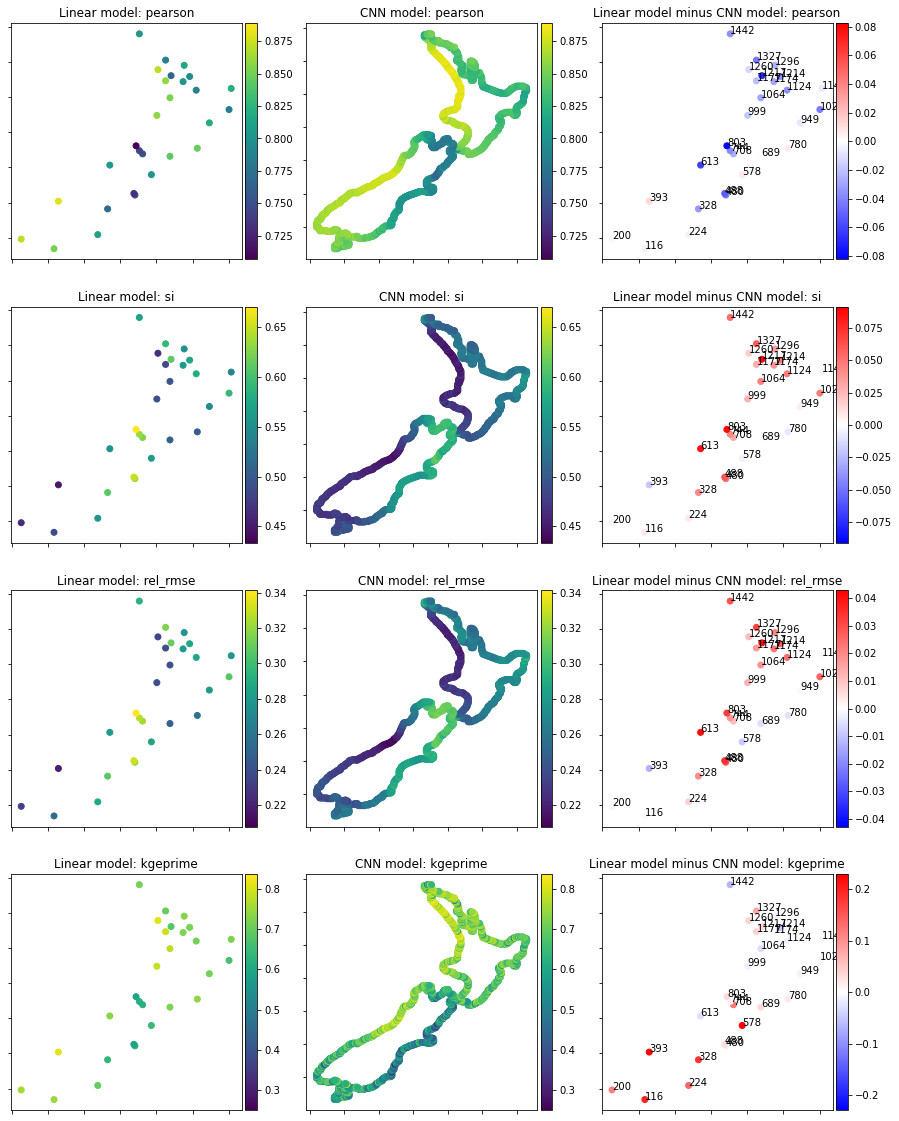

In [290]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

linear_results = xr.open_dataset('/home/metocean/geocean-nz-ss/data/statistics/experiments/experiment_linear_final_20211113.nc')
best_linear_results = linear_results.sel(grad=True, winds=True, tlapse=3, region='local_2.5_2.5', tresample='1D')
best_linear_results

metrics = ['pearson', 'si', 'rel_rmse', 'kgeprime']

sites_linear = [s for s in best_linear_results.site.values if s in list(results.keys())]
lons_linear = ss_dset.sel(site=sites_linear).lon.values
lats_linear = ss_dset.sel(site=sites_linear).lat.values

sites_nn = list(results.keys())
lons_nn = ss_dset.sel(site=sites_nn).lon.values
lats_nn = ss_dset.sel(site=sites_nn).lat.values

fig, axes = plt.subplots(ncols=3, nrows=len(metrics), figsize=(15,5*len(metrics)))

for im, metric in enumerate(metrics):
    
    vals_linear = best_linear_results.sel(site=sites_linear)[metric].values
    #vals_nn = stats_val[metric]
    vals_nn = np.array([r[0][metric] for r in results.values()])
    
    #vals_diff = vals_linear.squeeze() - np.array([stats_val[metric][np.where(sites_nn==s)[0][0]] for s in sites_linear]).squeeze()
    vals_diff = vals_linear.squeeze() - np.array([results[s][0][metric] for s in sites_linear]).squeeze()

    
    vmin = min(np.min(vals_linear), np.min(vals_nn))
    vmax = max(np.max(vals_linear), np.max(vals_nn))
    
    vdiff_max = np.max(np.abs(vals_diff))

    p=axes[im,0].scatter(lons_linear, lats_linear,
                      c=vals_linear, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,0].set_yticklabels([])
    axes[im,0].set_xticklabels([])
    axes[im,0].set_title("Linear model: "+metric)

    p=axes[im,1].scatter(lons_nn, lats_nn,
                      c=vals_nn, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,1].set_yticklabels([])
    axes[im,1].set_xticklabels([])
    axes[im,1].set_title("CNN model: "+metric)
    
    p=axes[im,2].scatter(lons_linear, lats_linear,
                         c=vals_diff, cmap='bwr', vmin=-vdiff_max, vmax=vdiff_max)
    divider = make_axes_locatable(axes[im,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,2].set_yticklabels([])
    axes[im,2].set_xticklabels([])
    axes[im,2].set_title("Linear model minus CNN model: "+metric)
    
    for i, txt in enumerate(sites_linear):
        axes[im,2].annotate(txt, (lons_linear[i], lats_linear[i]))

In [289]:
for r in results.values():
    print(r[0][metric])
    break

0.8443933019092555


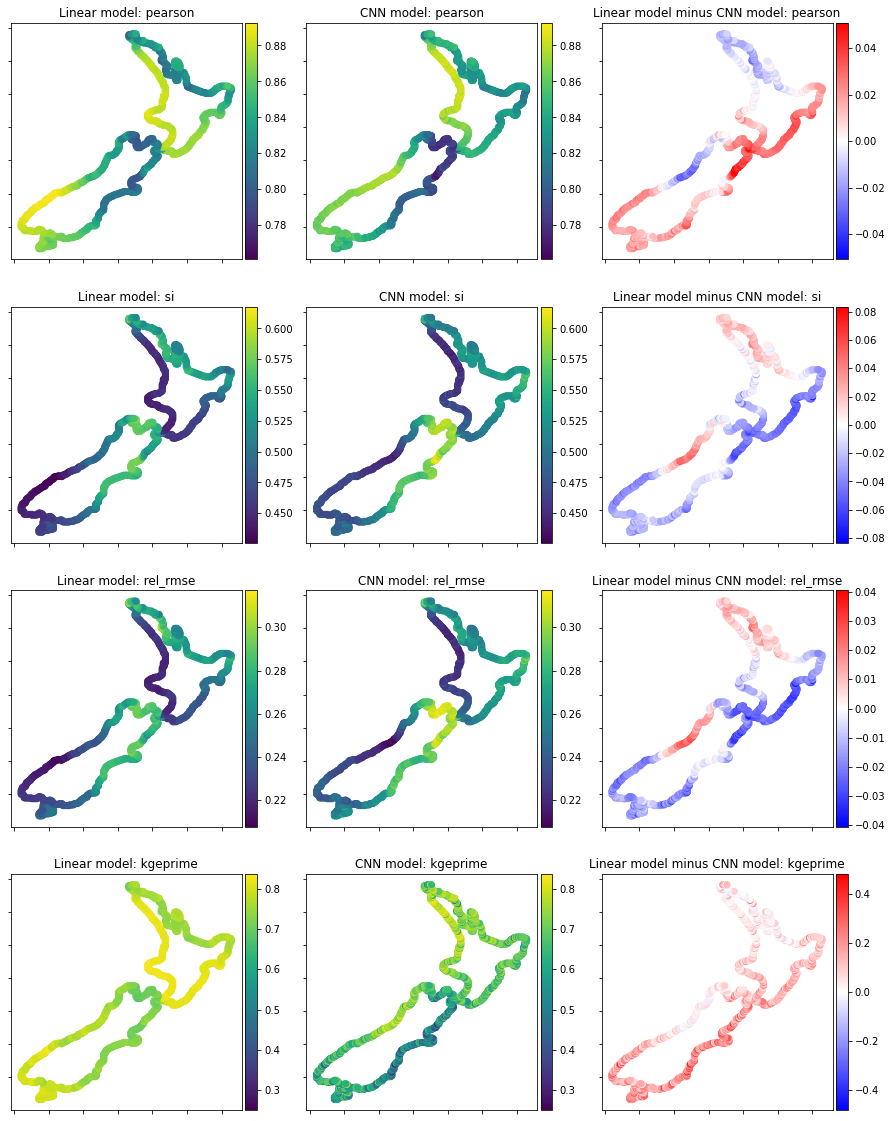

In [292]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

linear_results = xr.open_dataset('/home/metocean/geocean-nz-ss/data/statistics/experiments/linear_superfinal.nc')
best_linear_results = linear_results.squeeze()
best_linear_results

metrics = ['pearson', 'si', 'rel_rmse', 'kgeprime']

sites_linear = [s for s in best_linear_results.site.values if s in list(results.keys())]
lons_linear = ss_dset.sel(site=sites_linear).lon.values
lats_linear = ss_dset.sel(site=sites_linear).lat.values

sites_nn = list(results.keys())
lons_nn = ss_dset.sel(site=sites_nn).lon.values
lats_nn = ss_dset.sel(site=sites_nn).lat.values

fig, axes = plt.subplots(ncols=3, nrows=len(metrics), figsize=(15,5*len(metrics)))

for im, metric in enumerate(metrics):
    
    vals_linear = best_linear_results.sel(site=sites_linear)[metric].values
    #vals_nn = stats_val[metric]
    vals_nn = np.array([r[0][metric] for r in results.values()])
    
    #vals_diff = vals_linear.squeeze() - np.array([stats_val[metric][np.where(sites_nn==s)[0][0]] for s in sites_linear]).squeeze()
    vals_diff = vals_linear.squeeze() - np.array([results[s][0][metric] for s in sites_linear]).squeeze()

    
    vmin = min(np.min(vals_linear), np.min(vals_nn))
    vmax = max(np.max(vals_linear), np.max(vals_nn))
    
    vdiff_max = np.max(np.abs(vals_diff))

    p=axes[im,0].scatter(lons_linear, lats_linear,
                      c=vals_linear, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,0].set_yticklabels([])
    axes[im,0].set_xticklabels([])
    axes[im,0].set_title("Linear model: "+metric)

    p=axes[im,1].scatter(lons_nn, lats_nn,
                      c=vals_nn, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,1].set_yticklabels([])
    axes[im,1].set_xticklabels([])
    axes[im,1].set_title("CNN model: "+metric)
    
    p=axes[im,2].scatter(lons_linear, lats_linear,
                         c=vals_diff, cmap='bwr', vmin=-vdiff_max, vmax=vdiff_max)
    divider = make_axes_locatable(axes[im,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,2].set_yticklabels([])
    axes[im,2].set_xticklabels([])
    axes[im,2].set_title("Linear model minus CNN model: "+metric)
    
    #for i, txt in enumerate(sites_linear):
    #    axes[im,2].annotate(txt, (lons_linear[i], lats_linear[i]))